In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter
from random import sample
import re
from Bio import SeqIO

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#for adding heavy chain
complementator = str.maketrans("ACGT", "TGCA") 

In [4]:
df_category_cancers = pd.read_csv('../data/processed/mus_musculus/df_category_pqs_mus.csv')

In [5]:
df_category_mus_mut = pd.read_csv('../data/processed/df_category_mus_mut.csv')

In [6]:
refseq = str(next(SeqIO.parse('../data/raw/mus_musculus/mm10_ChrM_oneline.fasta', 'fasta')).seq)

In [7]:
g4pqs = pd.read_csv('../data/processed/mus_musculus/g4pqs_mus.csv')
df_loop_mut_mus = pd.read_csv('../data/processed/mus_musculus/df_loop_mut_pqs_mus.csv')
df_10_col_mut = pd.read_csv('../data/processed/mus_musculus/df_10_col_mut_pqs_mus.csv')
df_tetrads_mut_mus = pd.read_csv('../data/processed/mus_musculus/df_tetrads_mut_pqs_mus.csv')

In [8]:
df_all = pd.read_csv('../data/processed/mus_musculus/all_mut_mus.csv')

In [9]:
def get_norm_mutspec_aj(df):
    
    normMut = pd.DataFrame()
    
    normMut[['A>C','A>G','A>T']] = df[['A>C','A>G','A>T']].div(df['A'], axis=0)
    normMut[['C>A','C>G','C>T']] = df[['C>A','C>G','C>T']].div(df['C'], axis=0)
    normMut[['G>A', 'G>C', 'G>T']] = df[['G>A', 'G>C', 'G>T']].div(df['G'], axis=0)
    normMut[['T>A', 'T>C', 'T>G']] = df[['T>A', 'T>C', 'T>G']].div(df['T'], axis=0)
    
    normMut = normMut.fillna(0)
    normMut = normMut.div(normMut.sum(axis=1), axis=0) #normalizing (aj)
    
    # normMut.columns = normMut.columns.str.translate(complementator)
    
    return normMut

In [10]:
def get_norm_mutspec_waj(df):
    
    normMut = pd.DataFrame()
    
    normMut[['A>C','A>G','A>T']] = df[['A>C','A>G','A>T']].div(df['A'], axis=0)
    normMut[['C>A','C>G','C>T']] = df[['C>A','C>G','C>T']].div(df['C'], axis=0)
    normMut[['G>A', 'G>C', 'G>T']] = df[['G>A', 'G>C', 'G>T']].div(df['G'], axis=0)
    normMut[['T>A', 'T>C', 'T>G']] = df[['T>A', 'T>C', 'T>G']].div(df['T'], axis=0)
    
    normMut = normMut.fillna(0)
    # normMut = normMut.div(normMut.sum(axis=1), axis=0) #normalizing (waj)
    
    # normMut.columns = normMut.columns.str.translate(complementator)
    
    return normMut

In [11]:
def add_col_to_norm_mutspec(normMut:pd.DataFrame, df:pd.DataFrame):
    normMut.insert(0, 'G4_id', df['G4_id'])
    normMut.insert(1, 'side', df['side'])
    normMut = normMut.fillna(0)
    return normMut

In [70]:
g4pqs

sequenceName  start    end  score strand  \
0          chrM    904    923     29      -   
1          chrM   1095   1118     17      -   
2          chrM   2768   2808     26      -   
3          chrM   3012   3031     30      -   
4          chrM   3316   3344     19      -   
5          chrM   3905   3937     19      -   
6          chrM   4215   4241     25      -   
7          chrM   4504   4526     23      -   
8          chrM   4920   4937     69      -   
9          chrM   5394   5416     15      +   
10         chrM   5576   5611     17      -   
11         chrM   5714   5739     26      -   
12         chrM   7021   7055     21      -   
13         chrM   7508   7539     35      -   
14         chrM  10019  10056     38      -   
15         chrM  10943  10962     24      -   
16         chrM  13054  13084     36      -   
17         chrM  13353  13389     17      -   
18         chrM  13644  13665     31      -   
19         chrM  13773  13804     23      -   
20         chrM  13868  13890     31      -   
21         chrM  13936  13965     22      -   
22         chrM  14900  14943     54      -   
23         chrM  15375  15391     35      -   
24         chrM  15664  15708     48      -   
25         chrM  15714  15731     54      -   
26         chrM  16088  16124     71      -   

                                              pattern  nt  nb  nm  rl1  ...  \
0                    [C(A)CC]G[CCC]GTCA[CCC]T[CC(T)C]   3   2   0    4  ...   
1                  [C(TAAT)CC]TAG[CCC]TAG[CCC]TA[CaC]   3   1   1    7  ...   
2   [CC(TAACACT)CC]TCGT[CCCC]ATTCTAAT[CgCC]ATAG[CC...   4   2   1   11  ...   
3                    [CCC][C(TA)CC]AATA[CC(A)C]A[CCC]   3   2   0    3  ...   
4           [CCC]TAGCAGAAA[C(AAA)CC]GGG[CCC][CC(TT)C]   3   2   0    3  ...   
5       [CCC]GTA[C(TAATAAAT)CC]TATCA[CCC]TTG[CC(AT)C]   3   2   0    3  ...   
6             [CCC]TAT[CC(ATAAAA)C]TAGG[CC(T)C]G[CCC]   3   2   0    3  ...   
7                   [CCC]AT[CCC]T[CaC]T[C(TACTCAA)CC]   3   1   1    3  ...   
8                          [CCC]TAC[CCC]TAG[CCC][CCC]   3   0   0    3  ...   
9                   [GG(A)G]CCT[GaG]C[GGG]AATAGT[GGG]   3   1   1    4  ...   
10   [CCC]ACTAATAAT[C(GGAG)CC][CC(AGATATAG)C]ATT[CCC]   3   2   0    3  ...   
11             [CCC]A[CC(T)C]TAG[CC(GGAAAT)C]TAG[CCC]   3   2   0    3  ...   
12    [CCC]ATT[CC(AACTTGGT)C]TA[C(AAGACG)CC]ACAT[CCC]   3   2   0    3  ...   
13         [CCC]T[CCC]TAGGACTTAAAA[C(TGATG)CC]AT[CCC]   3   1   0    3  ...   
14  [CCC(TAAA)C]T[CC(AACT)CC]ATAAGCT[CC(ATA)CC]AAT...   4   3   0    8  ...   
15                     [CCC][C(TTCAT)CC]TT[CtC]T[CCC]   3   1   1    3  ...   
16          [CCC][CCC]TAATCT[CC(ATTAA)C]GAAAATGA[CCC]   3   1   0    3  ...   
17  [CCC]ATAAAAT[C(TCTCAA)CC]TAAG[CC(TAAAAA)C]AT[CCC]   3   2   0    3  ...   
18                 [CC(GCTA)C][CCC]AAT[CCC]T[CC(TT)C]   3   2   0    7  ...   
19       [CC(TCTATAAT)C]A[CCC][CC(AATA)C]TAAAAAA[CCC]   3   2   0   11  ...   
20                [CC(AAACA)C]AA[CC(AA)C]AT[CCC][CCC]   3   2   0    8  ...   
21         [CCC]TAAAA[CC(ATTAAA)C]AA[CC(AA)C]AAA[CCC]   3   2   0    3  ...   
22  [CCC(AGACAA)C]TACATA[CC(AGCTAAT)CC]ACTAAACA[CC...   4   2   0   10  ...   
23                      [CCC][C(A)CC]A[CC(AG)C]A[CCC]   3   2   0    3  ...   
24  [CCCC]TT[CCCC]ATTTGGTCTATTAATCTA[CC(AT)CC]T[CC...   4   2   0    4  ...   
25                       [CCC]G[CCC]A[CC(AATG)C][CCC]   3   1   0    3  ...   
26    [CC(AAA)CC][CCCC]AC[CCCC]TCCTCTTAATGCCAAA[CCCC]   4   1   0    7  ...   

    bp_untill_next_G4  bp_untill_previous_G4  up_win  down_win    10_up  \
0                 172                    375     804      1023    894.0   
1                1650                    172     995      1218   1085.0   
2                 204                   1650    2668      2908   2758.0   
3                 285                    204    2912      3131   3002.0   
4                 561                    285    3216      3444   3306.0   
5                 278  

In [10]:
g4pqs.score.median()

26.0

### High number of mutations in tetrads

In [12]:
df_category_mus_mut

G4_id  pos_in_seq  pos_in_ref nuc category  A>C  A>G  A>T  C>A  C>G  C>T  \
0        1           0         904   C   Tetrad  0.0  0.0  0.0  2.0  0.0  3.0   
1        1           1         905   A   Bulges  0.0  2.0  1.0  0.0  0.0  0.0   
2        1           2         906   C   Tetrad  0.0  0.0  0.0  2.0  0.0  2.0   
3        1           3         907   C   Tetrad  0.0  0.0  0.0  1.0  0.0  3.0   
4        1           4         908   G     Loop  0.0  0.0  0.0  0.0  0.0  0.0   
..     ...         ...         ...  ..      ...  ...  ...  ...  ...  ...  ...   
776     27          32       16120   A     Loop  0.0  1.0  0.0  0.0  0.0  0.0   
777     27          33       16121   C   Tetrad  0.0  0.0  0.0  0.0  0.0  0.0   
778     27          34       16122   C   Tetrad  0.0  0.0  0.0  0.0  0.0  0.0   
779     27          35       16123   C   Tetrad  0.0  0.0  0.0  0.0  1.0  2.0   
780     27          36       16124   C   Tetrad  0.0  0.0  0.0  0.0  0.0  2.0   

      G>A  G>C  G>T  T>A  T>C  T>G  number_of_Mut  
0     0.0  0.0  0.0  0.0  0.0  0.0            5.0  
1     0.0  0.0  0.0  0.0  0.0  0.0            3.0  
2     0.0  0.0  0.0  0.0  0.0  0.0            4.0  
3     0.0  0.0  0.0  0.0  0.0  0.0            4.0  
4    25.0  1.0  3.0  0.0  0.0  0.0           29.0  
..    ...  ...  ...  ...  ...  ...            ...  
776   0.0  0.0  0.0  0.0  0.0  0.0            1.0  
777   0.0  0.0  0.0  0.0  0.0  0.0            0.0  
778   0.0  0.0  0.0  0.0  0.0  0.0            0.0  
779   0.0  0.0  0.0  0.0  0.0  0.0            3.0  
780   0.0  0.0  0.0  0.0  0.0  0.0            2.0  

[781 rows x 18 columns]

In [67]:
muts_in_tetrads = df_category_mus_mut[((df_category_mus_mut['category'] == 'Tetrad') | \
                                           (df_category_mus_mut['category'] == 'Mismatch'))] \
    .melt(['G4_id', 'pos_in_seq', 'pos_in_ref'], 
          ['A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'G>A', 'G>C', 'G>T', 'T>A', 'T>C', 'T>G'], 'sbs', 'count')

muts_in_tetrads = muts_in_tetrads[muts_in_tetrads['count'] > 0]
muts_in_tetrads

G4_id  pos_in_seq  pos_in_ref  sbs  count
95        8          10        4514  A>C    1.0
366       2          22        1117  A>G    1.0
460      10           8        5402  A>G    1.0
783       8          10        4514  A>T    1.0
1032      1           0         904  C>A    2.0
...     ...         ...         ...  ...    ...
2872     10          13        5407  G>T    3.0
2873     10          20        5414  G>T    2.0
2874     10          21        5415  G>T    1.0
2875     10          22        5416  G>T    2.0
3635     16          14       10957  T>C    3.0

[567 rows x 5 columns]

In [68]:
muts_in_tetrads.groupby('sbs')['count'].sum().sort_values(ascending=False)

sbs
C>T    994.0
C>A    325.0
C>G    152.0
G>A    100.0
G>T     25.0
G>C      9.0
T>C      3.0
A>G      2.0
A>C      1.0
A>T      1.0
Name: count, dtype: float64

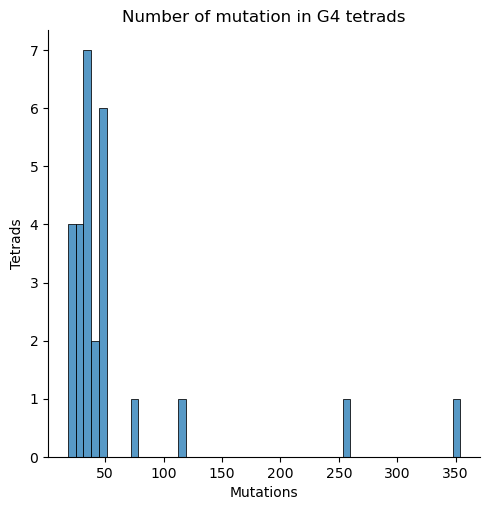

In [60]:
sns.displot(muts_in_tetrads.groupby(['G4_id'])['count'].sum(), bins=50) \
    .set(title='Number of mutation in G4 tetrads', xlabel='Mutations', ylabel='Tetrads')

In [16]:
muts_in_tetrads.groupby(['G4_id'])['count'].sum().sort_values(ascending=False)

G4_id
25    354.0
26    257.0
10    113.0
23     74.0
14     51.0
5      49.0
12     48.0
3      46.0
8      46.0
18     45.0
11     43.0
1      41.0
15     37.0
24     37.0
2      36.0
9      35.0
19     35.0
16     34.0
20     33.0
7      31.0
21     29.0
4      29.0
13     28.0
6      22.0
17     21.0
22     20.0
27     18.0
Name: count, dtype: float64

In [61]:
g4_rm = [25, 26, 10, 23]

In [62]:
g4pqs[g4pqs['G4_id'].isin(g4_rm)]

sequenceName  start    end  score strand  \
9          chrM   5394   5416     15      +   
22         chrM  14900  14943     54      -   
24         chrM  15664  15708     48      -   
25         chrM  15714  15731     54      -   

                                              pattern  nt  nb  nm  rl1  ...  \
9                   [GG(A)G]CCT[GaG]C[GGG]AATAGT[GGG]   3   1   1    4  ...   
22  [CCC(AGACAA)C]TACATA[CC(AGCTAAT)CC]ACTAAACA[CC...   4   2   0   10  ...   
24  [CCCC]TT[CCCC]ATTTGGTCTATTAATCTA[CC(AT)CC]T[CC...   4   2   0    4  ...   
25                       [CCC]G[CCC]A[CC(AATG)C][CCC]   3   1   0    3  ...   

    bp_untill_next_G4  bp_untill_previous_G4  up_win  down_win    10_up  \
9                 160                    457    5294      5516   5384.0   
22                432                    935   14800     15043  14890.0   
24                  6                    273   15564     15714  15654.0   
25                357                      6   15708     15831      0.0   

    10_down    20_up  20_down    30_up  30_down  
9    5426.0   5374.0   5436.0   5364.0   5446.0  
22  14953.0  14880.0  14963.0  14870.0  14973.0  
24      0.0  15644.0      0.0  15634.0      0.0  
25  15741.0      0.0  15751.0      0.0  15761.0  

[4 rows x 27 columns]

In [69]:
muts_in_tetrads[~muts_in_tetrads['G4_id'].isin(g4_rm)].groupby('sbs')['count'].sum().sort_values(ascending=False)

sbs
C>T    425.0
C>A    252.0
C>G    109.0
G>A     18.0
T>C      3.0
G>C      2.0
G>T      2.0
A>C      1.0
A>G      1.0
A>T      1.0
Name: count, dtype: float64

### Number of mut in loops

In [73]:
muts_in_loops = df_category_mus_mut[(df_category_mus_mut['category'] == 'Loop')] \
    .melt(['G4_id', 'pos_in_seq', 'pos_in_ref'], 
          ['A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'G>A', 'G>C', 'G>T', 'T>A', 'T>C', 'T>G'], 'sbs', 'count')

muts_in_loops = muts_in_loops[muts_in_loops['count'] > 0]
muts_in_loops

G4_id  pos_in_seq  pos_in_ref  sbs  count
7         2           8        1103  A>C    1.0
34        4          16        3028  A>C    1.0
90       11           7        5583  A>C    1.0
95       11          30        5606  A>C    1.0
98       12           3        5717  A>C    1.0
...     ...         ...         ...  ...    ...
2787     27          26       16114  T>C    2.0
2829      5           3        3319  T>G    1.0
2876     10          16        5410  T>G    1.0
2888     11          11        5587  T>G    1.0
2933     15          33       10052  T>G    1.0

[263 rows x 5 columns]

In [74]:
muts_in_loops.groupby('sbs')['count'].sum().sort_values(ascending=False)

sbs
G>A    822.0
T>C    210.0
C>T     90.0
G>T     72.0
A>G     69.0
G>C     32.0
C>A     23.0
C>G     18.0
A>T     14.0
A>C     13.0
T>A      9.0
T>G      4.0
Name: count, dtype: float64

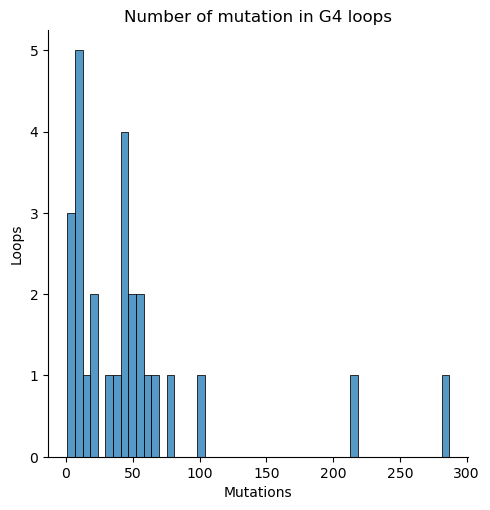

In [75]:
sns.displot(muts_in_loops.groupby(['G4_id'])['count'].sum(), bins=50) \
    .set(title='Number of mutation in G4 loops', xlabel='Mutations', ylabel='Loops')

In [76]:
muts_in_loops.groupby(['G4_id'])['count'].sum().sort_values(ascending=False)

G4_id
25    287.0
5     213.0
7     102.0
26     80.0
12     64.0
1      62.0
3      58.0
2      53.0
14     52.0
17     48.0
6      44.0
18     44.0
9      43.0
15     43.0
10     38.0
23     32.0
27     22.0
11     19.0
8      17.0
20     10.0
19     10.0
22      9.0
13      8.0
4       8.0
16      5.0
21      4.0
24      1.0
Name: count, dtype: float64

## MutSpec, aj

In [19]:
norm_10_col = add_col_to_norm_mutspec(get_norm_mutspec_aj(df_10_col_mut).fillna(0), df_10_col_mut)
norm_loop = add_col_to_norm_mutspec(get_norm_mutspec_aj(df_loop_mut_mus).fillna(0), df_loop_mut_mus)
norm_tetrads = add_col_to_norm_mutspec(get_norm_mutspec_aj(df_tetrads_mut_mus).fillna(0), df_tetrads_mut_mus)

In [20]:
norm_10_col['location'] = norm_10_col['side'].str.replace('10_up', '-10').replace('10_down', '10') \
                            .replace('20_up', '-20').replace('20_down', '20') \
                            .replace('30_up', '-30').replace('30_down', '30')
norm_loop['location'] = 0
norm_tetrads['location'] = 0

In [21]:
norm_merged_loop_aj = pd.concat([norm_10_col,norm_loop])

In [22]:
norm_merged_tetrads_aj = pd.concat([norm_10_col,norm_tetrads])

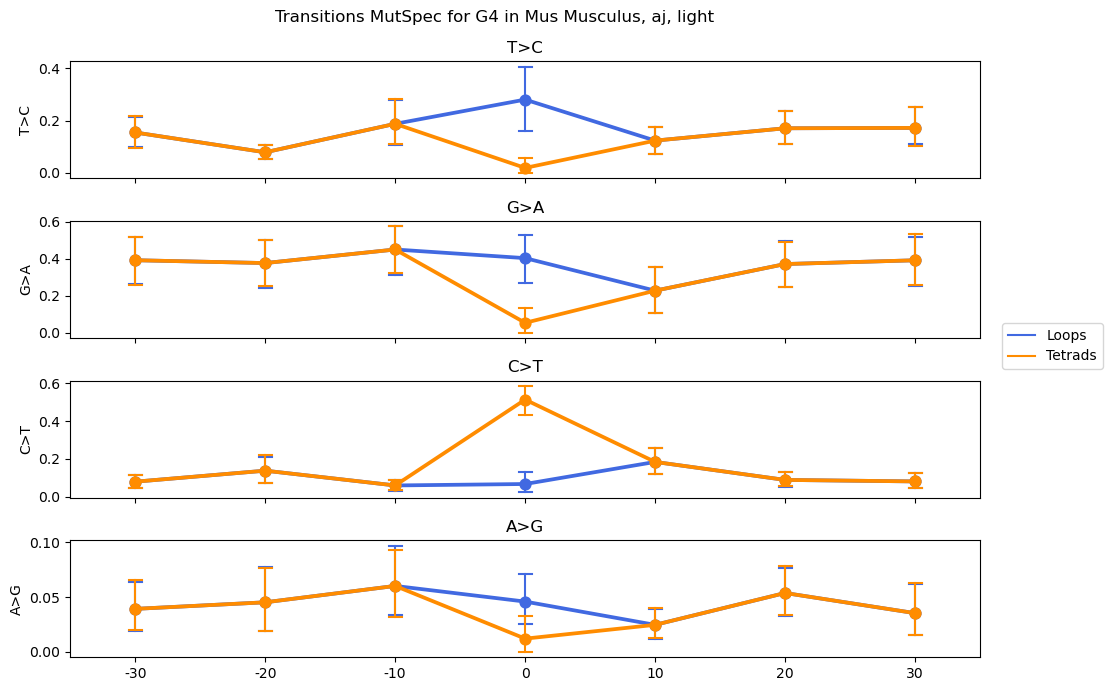

In [16]:
fig, axs = plt.subplots(4, sharex=True,  figsize=(10, 7))
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = [-30, -20, -10, 0, 10, 20, 30]

for i, mutation in enumerate(mutations):
    row = i % 4
    sns.pointplot(data=norm_merged_loop_aj, 
                 x=norm_merged_loop_aj['location'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)
    sns.pointplot(data=norm_merged_tetrads_aj, 
                 x=norm_merged_tetrads_aj['location'], y=mutation, ax=axs[row], color=colors[1], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)

# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Loops', 'Tetrads']
# Add legend with custom handles and labels
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Transitions MutSpec for G4 in Mus Musculus, aj, light')
plt.tight_layout()
plt.show()

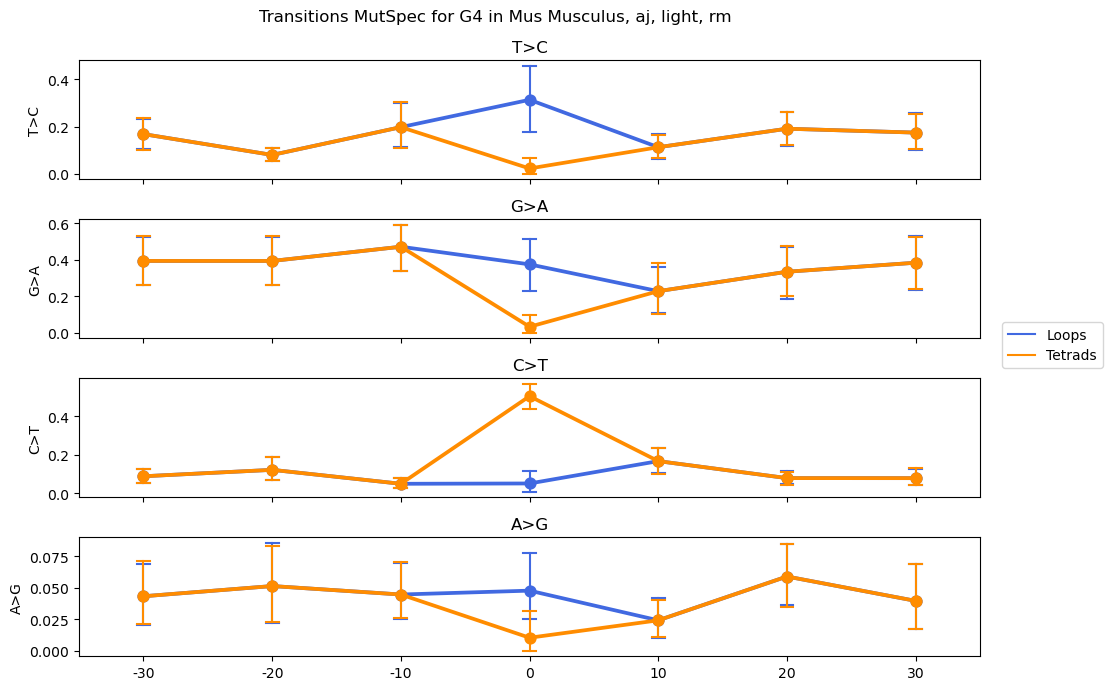

In [66]:
fig, axs = plt.subplots(4, sharex=True,  figsize=(10, 7))
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = [-30, -20, -10, 0, 10, 20, 30]

for i, mutation in enumerate(mutations):
    row = i % 4
    sns.pointplot(data=norm_merged_loop_aj[~norm_merged_loop_aj['G4_id'].isin(g4_rm)], 
                 x='location', y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)
    sns.pointplot(data=norm_merged_tetrads_aj[~norm_merged_tetrads_aj['G4_id'].isin(g4_rm)], 
                 x='location', y=mutation, ax=axs[row], color=colors[1], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)

# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Loops', 'Tetrads']
# Add legend with custom handles and labels
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Transitions MutSpec for G4 in Mus Musculus, aj, light, rm')
plt.tight_layout()
plt.show()

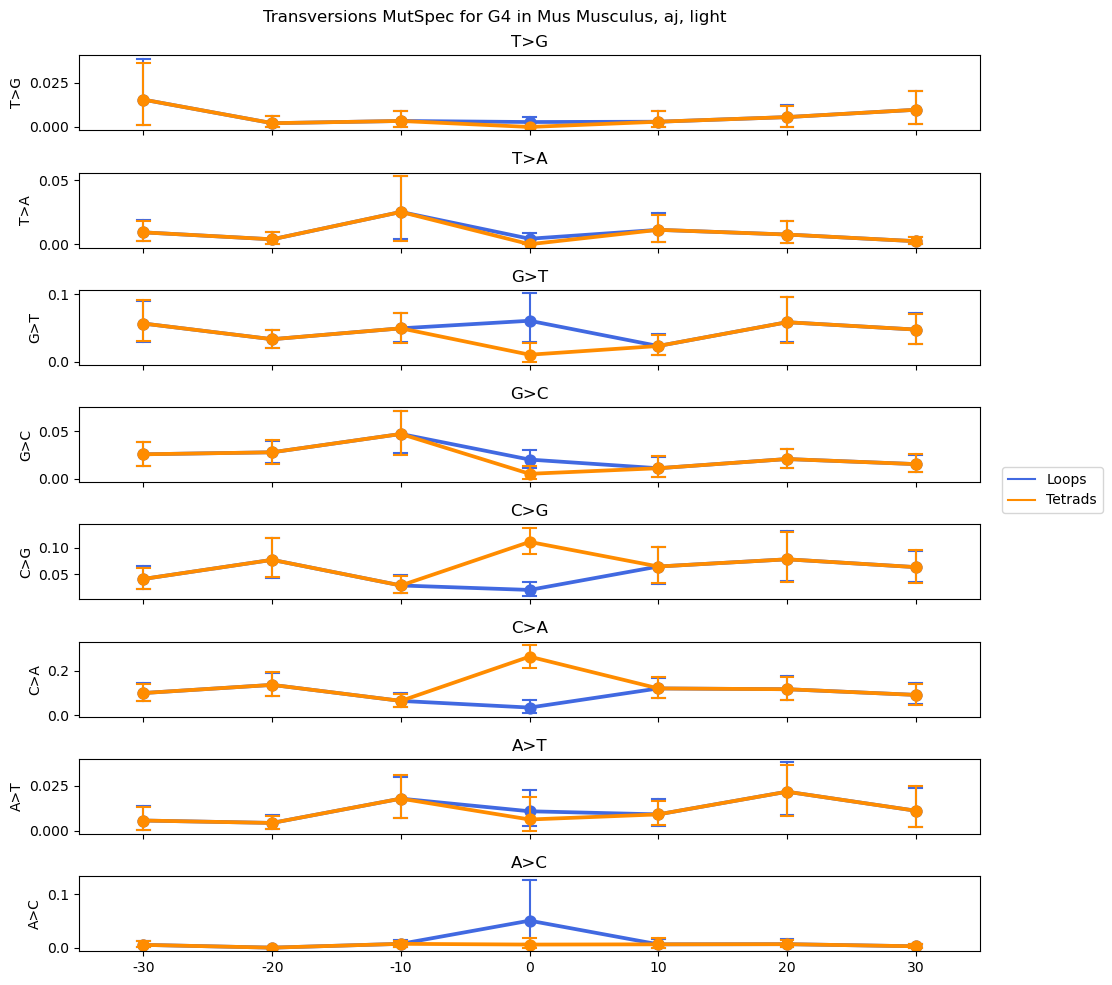

In [59]:
fig, axs = plt.subplots(8, sharex=True, figsize=(10, 10))
mutations = ['T>G', 'T>A', 'G>T', 'G>C', 'C>G', 'C>A', 'A>T', 'A>C']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = [-30, -20, -10, 0, 10, 20, 30]

for i, mutation in enumerate(mutations):
    row = i % 8
    sns.pointplot(data=norm_merged_loop_aj, 
                 x='location', y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)
    sns.pointplot(data=norm_merged_tetrads_aj, 
                 x='location', y=mutation, ax=axs[row], color=colors[1], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)

# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Loops', 'Tetrads']
# Add legend with custom handles and labels
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Transversions MutSpec for G4 in Mus Musculus, aj, light')
plt.tight_layout()
plt.show()

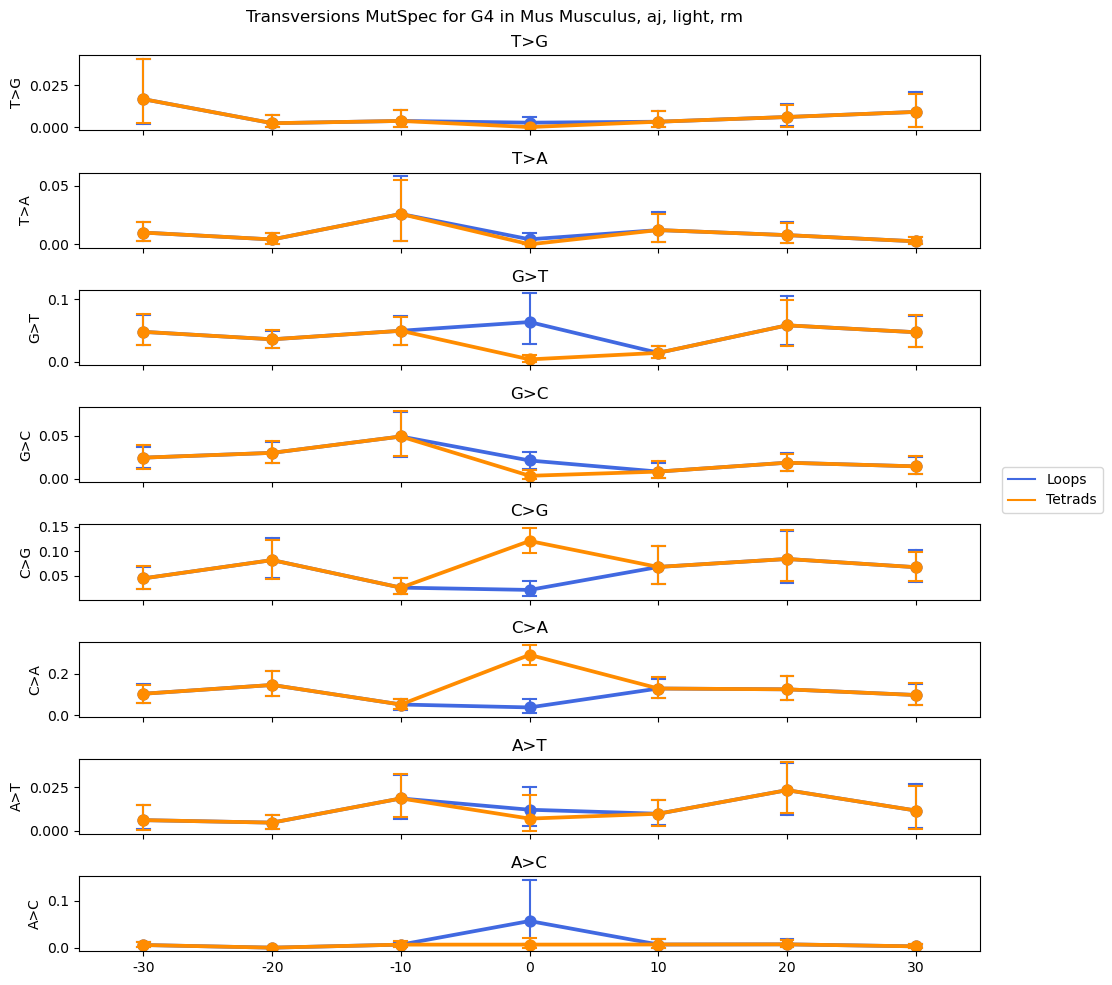

In [57]:
fig, axs = plt.subplots(8, sharex=True, figsize=(10, 10))
mutations = ['T>G', 'T>A', 'G>T', 'G>C', 'C>G', 'C>A', 'A>T', 'A>C']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = [-30, -20, -10, 0, 10, 20, 30]

for i, mutation in enumerate(mutations):
    row = i % 8
    sns.pointplot(data=norm_merged_loop_aj[~norm_merged_loop_aj['G4_id'].isin(g4_rm)], 
                 x='location', y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)
    sns.pointplot(data=norm_merged_tetrads_aj[~norm_merged_tetrads_aj['G4_id'].isin(g4_rm)], 
                 x='location', y=mutation, ax=axs[row], color=colors[1], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)

# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Loops', 'Tetrads']
# Add legend with custom handles and labels
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Transversions MutSpec for G4 in Mus Musculus, aj, light, rm')
plt.tight_layout()
plt.show()

In [23]:
df_loop_mut_mus['n_mut/length'] = df_loop_mut_mus['number_of_Mut']/df_loop_mut_mus['sequence'].apply(lambda x:len(x))

In [24]:
df_10_col_mut['n_mut/length'] = df_10_col_mut['number_of_Mut']/10

In [25]:
df_mut_concat = pd.concat([df_loop_mut_mus, df_10_col_mut]) 

In [26]:
df_tetrads_mut_mus['n_mut/length'] = df_tetrads_mut_mus['number_of_Mut']/df_tetrads_mut_mus['sequence'].apply(lambda x:len(x))

In [27]:
df_mut_concat_tetrads = pd.concat([df_tetrads_mut_mus, df_10_col_mut]) 

In [28]:
colors = ['royalblue', 'darkorange', 'tomato', 'orchid'] 
order_l = ['30_up', '20_up', '10_up', 'loops', '10_down', '20_down', '30_down']
order_t = ['30_up', '20_up', '10_up', 'tetrads', '10_down', '20_down', '30_down']

In [20]:
# fig, axs = plt.subplots(4, sharex=True, sharey=True,  figsize=(10, 7))
# mutations = ['T', 'G', 'C', 'A']

# colors = ['royalblue', 'darkorange', 'tomato', 'orchid'] 
# order = ['30_up', '20_up', '10_up', 'loops', '10_down', '20_down', '30_down']

# for i, mutation in enumerate(mutations):
#     row = i % 4
#     sns.pointplot(data=df_mut_concat, 
#                  x=df_mut_concat['side'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
#         .set(title=mutation.translate(complementator), xlabel=None, ylabel=None)


# plt.suptitle('Number of nucleotids for G4 in Mus Musculus')
# plt.tight_layout()
# plt.show()

In [21]:
# sns.pointplot(data=df_mut_concat, 
#                  x=df_mut_concat['side'], y=df_mut_concat['n_mut/length'], 
#               color=colors[0], order=order, capsize=.1, errwidth=1.5) \
#         .set(title='Number of Mut / interval length in G4 Mus', xlabel=None, ylabel=None)

[Text(0.5, 1.0, 'Mut ratio in G4 Mus, Mut/site'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

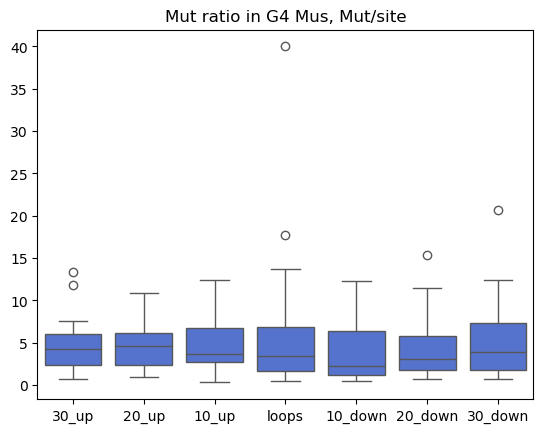

In [25]:
sns.boxplot(data=df_mut_concat, 
                 x=df_mut_concat['side'], y=df_mut_concat['n_mut/length'], 
              color=colors[0], order=order_l) \
        .set(title='Mut ratio in G4 Mus, Mut/site', xlabel=None, ylabel=None)

[Text(0.5, 1.0, 'Mut ratio in G4 Mus, Mut/site, rm'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

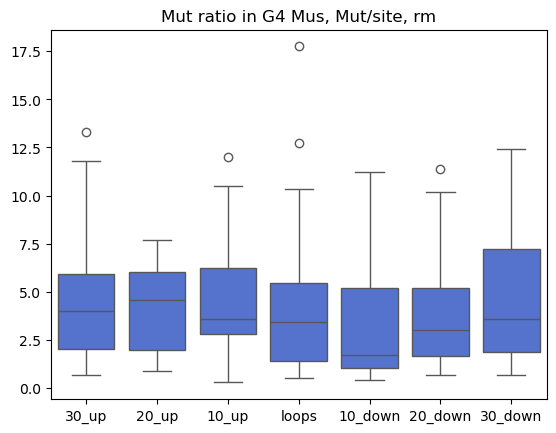

In [64]:
sns.boxplot(data=df_mut_concat[~df_mut_concat['G4_id'].isin(g4_rm)], 
                 x='side', y='n_mut/length', 
              color=colors[0], order=order_l) \
        .set(title='Mut ratio in G4 Mus, Mut/site, rm', xlabel=None, ylabel=None)

In [29]:
df_mut_concat[df_mut_concat['n_mut/length'] > 30]

G4_id   side       positions sequence    A    C    G    T  A>C  A>G  ...  \
25     26  loops  [15717, 15721]       GA  1.0  0.0  1.0  0.0  0.0  2.0  ...   

     G>A  G>C  G>T  T>A  T>C  T>G  number_of_Mut  n_mut/length  window_start  \
25  74.0  2.0  2.0  0.0  0.0  0.0           80.0          40.0           NaN   

    window_end  
25         NaN  

[1 rows x 24 columns]

[Text(0.5, 1.0, 'Number of Mut / interval length < 30 in G4 Mus'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

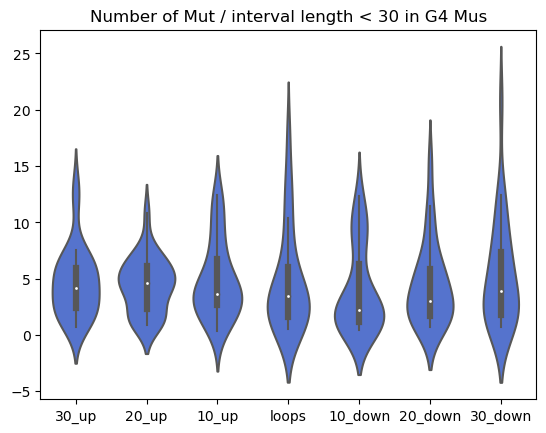

In [31]:
sns.violinplot(data=df_mut_concat[df_mut_concat['n_mut/length'] < 30], 
                 x='side', y='n_mut/length', 
              color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title='Number of Mut / interval length < 30 in G4 Mus', xlabel=None, ylabel=None)

In [28]:
# sns.pointplot(data=df_mut_concat_tetrads, 
#                  x=df_mut_concat_tetrads['side'], y=df_mut_concat_tetrads['n_mut/length'], 
#               color=colors[0], order=order, capsize=.1, errwidth=1.5) \
#         .set(title='Number of Mut / interval length in G4 Mus', xlabel=None, ylabel=None)

[Text(0.5, 1.0, 'Mut ratio in G4 Mus, Mut/site'),
 Text(0.5, 0, ''),
 Text(0, 0.5, ''),
 (0.0, 40.0)]

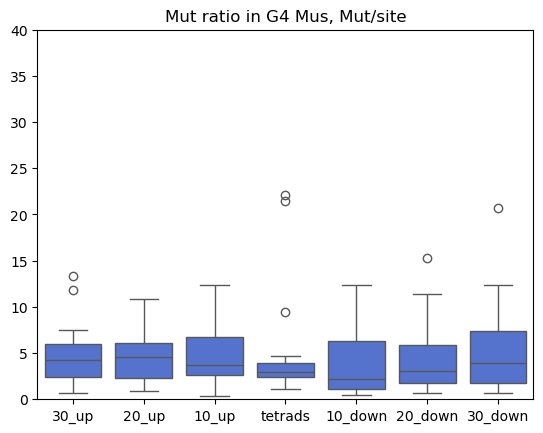

In [30]:
sns.boxplot(data=df_mut_concat_tetrads, 
                 x=df_mut_concat_tetrads['side'], y=df_mut_concat_tetrads['n_mut/length'], 
              color=colors[0], order=order_t) \
        .set(title='Mut ratio in G4 Mus, Mut/site', xlabel=None, ylabel=None, ylim=(0, 40))

[Text(0.5, 1.0, 'Mut ratio in G4 Mus, Mut/site, rm'),
 Text(0.5, 0, ''),
 Text(0, 0.5, ''),
 (0.0, 40.0)]

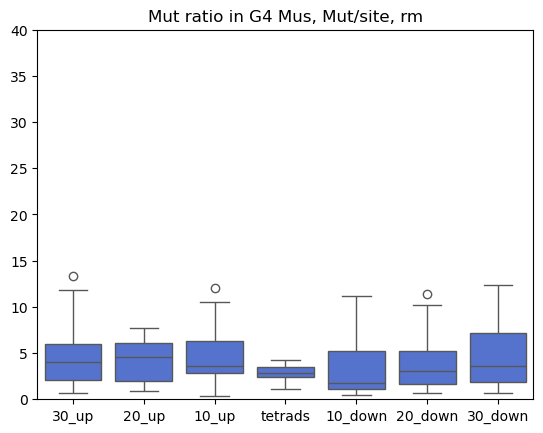

In [65]:
sns.boxplot(data=df_mut_concat_tetrads[~df_mut_concat_tetrads['G4_id'].isin(g4_rm)], 
                 x='side', y='n_mut/length', 
              color=colors[0], order=order_t) \
        .set(title='Mut ratio in G4 Mus, Mut/site, rm', xlabel=None, ylabel=None, ylim=(0, 40))

C:\Users\777\AppData\Local\Temp\ipykernel_5168\2894568541.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


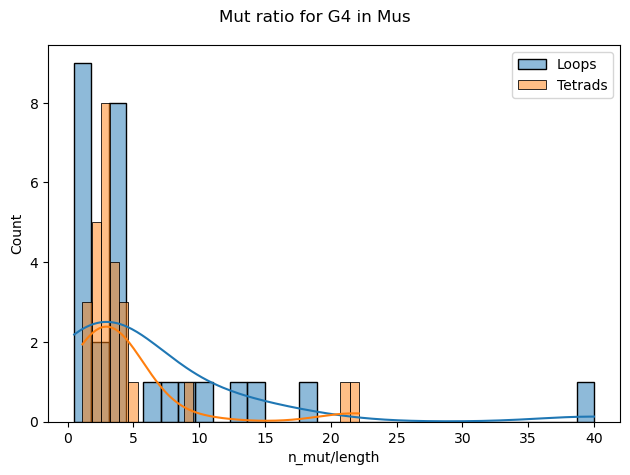

In [38]:
fig, axs = plt.subplots()
sns.histplot(df_mut_concat[df_mut_concat['side']=='loops']['n_mut/length'], bins=30, kde=True, label='Loops')
sns.histplot(df_mut_concat_tetrads[df_mut_concat_tetrads['side']=='tetrads']['n_mut/length'],bins=30, kde=True, label='Tetrads')
plt.suptitle('Mut ratio for G4 in Mus')
plt.legend()
plt.tight_layout()
fig.show()

C:\Users\777\AppData\Local\Temp\ipykernel_16980\479450413.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


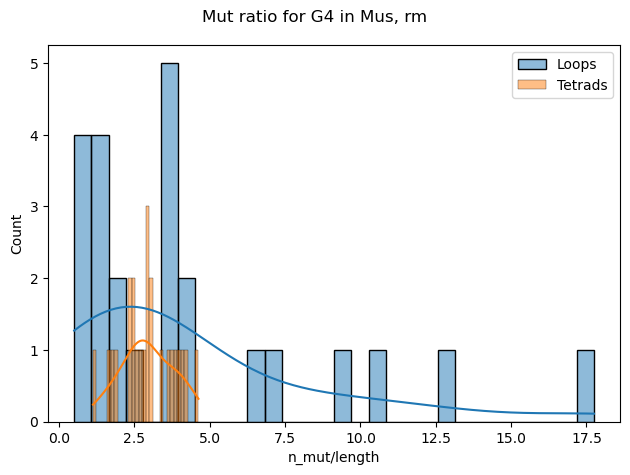

In [45]:
fig, axs = plt.subplots()
sns.histplot(df_mut_concat[(df_mut_concat['side']=='loops') & (~df_mut_concat['G4_id'].isin(g4_rm))]['n_mut/length'], bins=30, kde=True, label='Loops')
sns.histplot(df_mut_concat_tetrads[(df_mut_concat_tetrads['side']=='tetrads') & (~df_mut_concat_tetrads['G4_id'].isin(g4_rm))]['n_mut/length'], bins=30, kde=True, label='Tetrads')
plt.suptitle('Mut ratio for G4 in Mus, rm')
plt.legend()
plt.tight_layout()
fig.show()

In [48]:
df_mut_concat[(df_mut_concat['side']=='loops') & (~df_mut_concat['G4_id'].isin(g4_rm))]['n_mut/length'].median()

3.4065934065934065

In [49]:
df_mut_concat_tetrads[(df_mut_concat_tetrads['side']=='tetrads') & (~df_mut_concat_tetrads['G4_id'].isin(g4_rm))]['n_mut/length'].median()

2.895833333333333

## MutSpecs waj

In [50]:
norm_10_col_waj = add_col_to_norm_mutspec(get_norm_mutspec_waj(df_10_col_mut).fillna(0), df_10_col_mut)
norm_loop_waj = add_col_to_norm_mutspec(get_norm_mutspec_waj(df_loop_mut_mus).fillna(0), df_loop_mut_mus)
norm_tetrads_waj = add_col_to_norm_mutspec(get_norm_mutspec_waj(df_tetrads_mut_mus).fillna(0), df_tetrads_mut_mus)

In [51]:
norm_10_col_waj['location'] = norm_10_col_waj['side'].str.replace('10_up', '-10').replace('10_down', '10') \
                            .replace('20_up', '-20').replace('20_down', '20') \
                            .replace('30_up', '-30').replace('30_down', '30')
norm_loop_waj['location'] = 0
norm_tetrads_waj['location'] = 0

norm_10_col_waj['location'] = norm_10_col_waj['location'].astype('int')

In [52]:
norm_merged_loop_waj = pd.concat([norm_10_col_waj,norm_loop_waj]).reset_index(drop=True)

In [53]:
norm_merged_tetrads_waj = pd.concat([norm_10_col_waj,norm_tetrads_waj]).reset_index(drop=True)

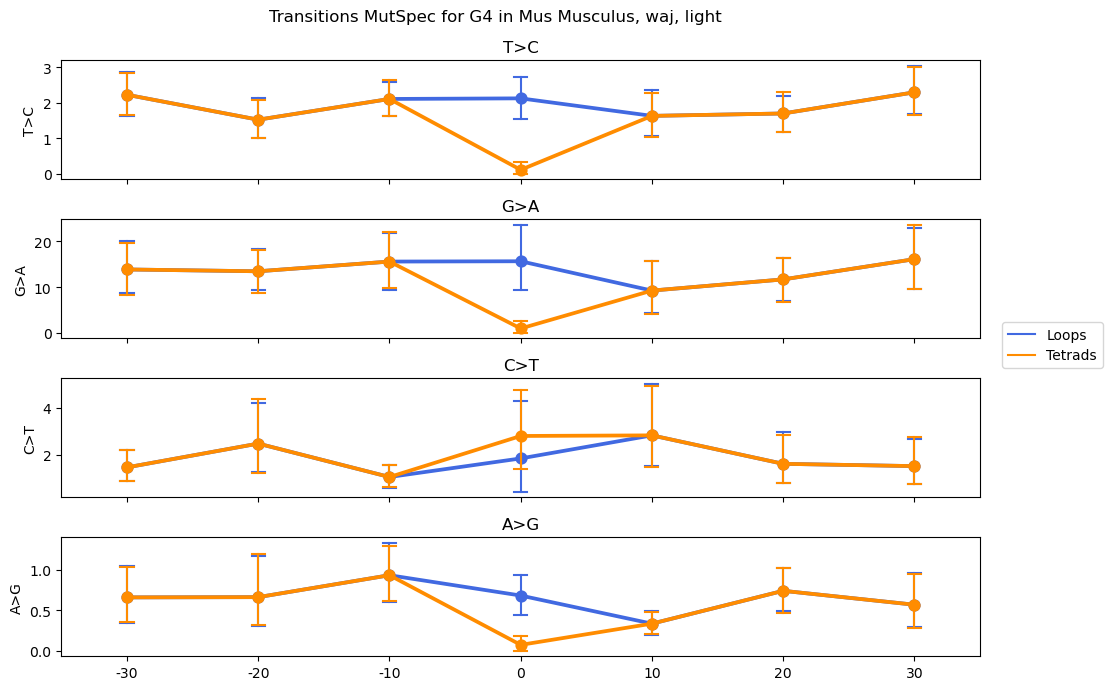

In [35]:
fig, axs = plt.subplots(4, sharex=True,  figsize=(10, 7))
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = [-30, -20, -10, 0, 10, 20, 30]

for i, mutation in enumerate(mutations):
    row = i % 4
    sns.pointplot(data=norm_merged_loop_waj, 
                 x=norm_merged_loop_waj['location'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)
    sns.pointplot(data=norm_merged_tetrads_waj, 
                 x=norm_merged_tetrads_waj['location'], y=mutation, ax=axs[row], color=colors[1], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)

# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Loops', 'Tetrads']
# Add legend with custom handles and labels
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Transitions MutSpec for G4 in Mus Musculus, waj, light')
plt.tight_layout()
plt.show()

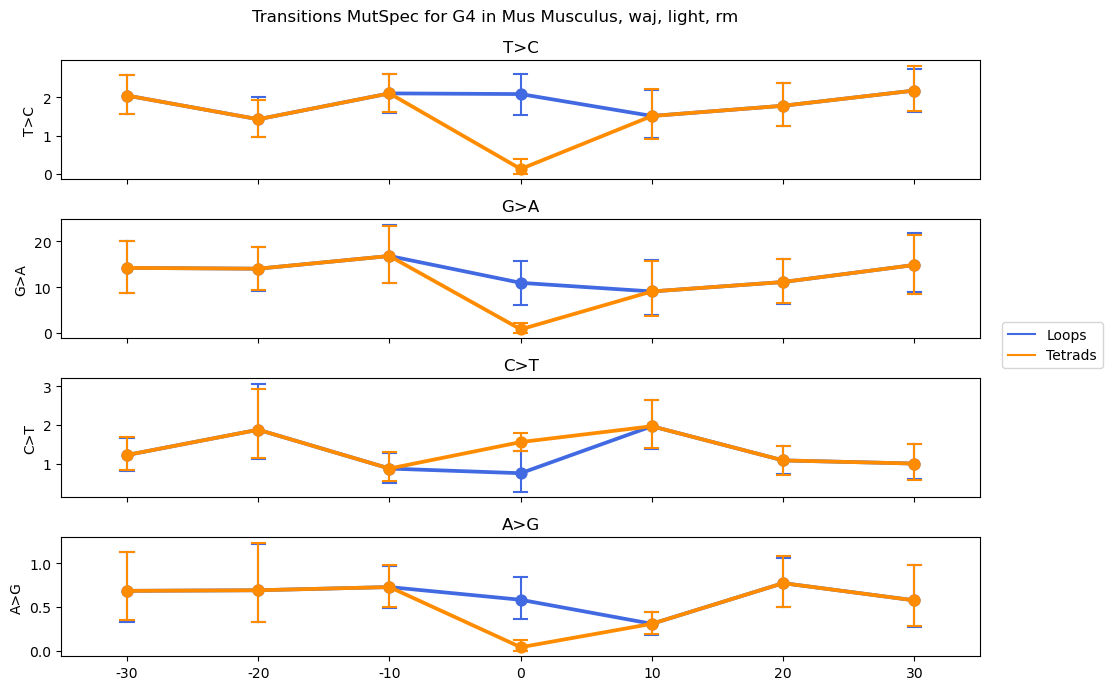

In [55]:
fig, axs = plt.subplots(4, sharex=True,  figsize=(10, 7))
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = [-30, -20, -10, 0, 10, 20, 30]

for i, mutation in enumerate(mutations):
    row = i % 4
    sns.pointplot(data=norm_merged_loop_waj[~norm_merged_loop_waj['G4_id'].isin(g4_rm)], 
                 x='location', y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)
    sns.pointplot(data=norm_merged_tetrads_waj[~norm_merged_tetrads_waj['G4_id'].isin(g4_rm)], 
                 x='location', y=mutation, ax=axs[row], color=colors[1], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)

# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Loops', 'Tetrads']
# Add legend with custom handles and labels
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Transitions MutSpec for G4 in Mus Musculus, waj, light, rm')
plt.tight_layout()
plt.show()

In [28]:
# compare C>T between loops and tetrads

print('C>T Loop|Tetrads', 'pval =', 
      stats.mannwhitneyu(norm_merged_loop_waj[norm_merged_loop_waj['side'] == 'loops']['C>T'], 
                         norm_merged_tetrads_waj[norm_merged_tetrads_waj['side'] == 'tetrads']['C>T']).pvalue)
print('C>T -10|Tetrads', 'pval =', 
      stats.mannwhitneyu(norm_merged_tetrads_waj[norm_merged_tetrads_waj['side'] == '10_up']['C>T'], 
                         norm_merged_tetrads_waj[norm_merged_tetrads_waj['side'] == 'tetrads']['C>T']).pvalue)
print('C>T 10|Tetrads', 'pval =', 
      stats.mannwhitneyu(norm_merged_tetrads_waj[norm_merged_tetrads_waj['side'] == '10_down']['C>T'], 
                         norm_merged_tetrads_waj[norm_merged_tetrads_waj['side'] == 'tetrads']['C>T']).pvalue)
print('C>T -20|Tetrads', 'pval =', 
      stats.mannwhitneyu(norm_merged_tetrads_waj[norm_merged_tetrads_waj['side'] == '20_up']['C>T'], 
                         norm_merged_tetrads_waj[norm_merged_tetrads_waj['side'] == 'tetrads']['C>T']).pvalue)
print('C>T 20|Tetrads', 'pval =', 
      stats.mannwhitneyu(norm_merged_tetrads_waj[norm_merged_tetrads_waj['side'] == '20_down']['C>T'], 
                         norm_merged_tetrads_waj[norm_merged_tetrads_waj['side'] == 'tetrads']['C>T']).pvalue)
print('C>T -30|Tetrads', 'pval =', 
      stats.mannwhitneyu(norm_merged_tetrads_waj[norm_merged_tetrads_waj['side'] == '30_up']['C>T'], 
                         norm_merged_tetrads_waj[norm_merged_tetrads_waj['side'] == 'tetrads']['C>T']).pvalue)
print('C>T 30|Tetrads', 'pval =', 
      stats.mannwhitneyu(norm_merged_tetrads_waj[norm_merged_tetrads_waj['side'] == '30_down']['C>T'], 
                         norm_merged_tetrads_waj[norm_merged_tetrads_waj['side'] == 'tetrads']['C>T']).pvalue)

C>T Loop|Tetrads pval = 0.0006679873155856822
C>T -10|Tetrads pval = 0.0008317575211191983
C>T 10|Tetrads pval = 0.12324884928806275
C>T -20|Tetrads pval = 0.4374767779770701
C>T 20|Tetrads pval = 0.02019157503747913
C>T -30|Tetrads pval = 0.055177040605194544
C>T 30|Tetrads pval = 0.020402660000669186


In [58]:
# compare C>T between loops and tetrads rm (without G4 with high num mut in tetrads)

print('C>T Loop|Tetrads', 'pval =', 
      stats.mannwhitneyu(norm_merged_loop_waj[(norm_merged_loop_waj['side'] == 'loops') & (~norm_merged_loop_waj['G4_id'].isin(g4_rm))]['C>T'], 
                         norm_merged_tetrads_waj[(norm_merged_tetrads_waj['side'] == 'tetrads') & (~norm_merged_tetrads_waj['G4_id'].isin(g4_rm))]['C>T']).pvalue)
print('C>T -10|Tetrads', 'pval =', 
      stats.mannwhitneyu(norm_merged_tetrads_waj[(norm_merged_tetrads_waj['side'] == '10_up') & (~norm_merged_tetrads_waj['G4_id'].isin(g4_rm))]['C>T'], 
                         norm_merged_tetrads_waj[(norm_merged_tetrads_waj['side'] == 'tetrads') & (~norm_merged_tetrads_waj['G4_id'].isin(g4_rm))]['C>T']).pvalue)
print('C>T 10|Tetrads', 'pval =', 
      stats.mannwhitneyu(norm_merged_tetrads_waj[(norm_merged_tetrads_waj['side'] == '10_down') & (~norm_merged_tetrads_waj['G4_id'].isin(g4_rm))]['C>T'], 
                         norm_merged_tetrads_waj[(norm_merged_tetrads_waj['side'] == 'tetrads') & (~norm_merged_tetrads_waj['G4_id'].isin(g4_rm))]['C>T']).pvalue)
print('C>T -20|Tetrads', 'pval =', 
      stats.mannwhitneyu(norm_merged_tetrads_waj[(norm_merged_tetrads_waj['side'] == '20_up') & (~norm_merged_tetrads_waj['G4_id'].isin(g4_rm))]['C>T'], 
                         norm_merged_tetrads_waj[(norm_merged_tetrads_waj['side'] == 'tetrads') & (~norm_merged_tetrads_waj['G4_id'].isin(g4_rm))]['C>T']).pvalue)
print('C>T 20|Tetrads', 'pval =', 
      stats.mannwhitneyu(norm_merged_tetrads_waj[(norm_merged_tetrads_waj['side'] == '20_down') & (~norm_merged_tetrads_waj['G4_id'].isin(g4_rm))]['C>T'], 
                         norm_merged_tetrads_waj[(norm_merged_tetrads_waj['side'] == 'tetrads') & (~norm_merged_tetrads_waj['G4_id'].isin(g4_rm))]['C>T']).pvalue)
print('C>T -30|Tetrads', 'pval =', 
      stats.mannwhitneyu(norm_merged_tetrads_waj[(norm_merged_tetrads_waj['side'] == '30_up') & (~norm_merged_tetrads_waj['G4_id'].isin(g4_rm))]['C>T'], 
                         norm_merged_tetrads_waj[(norm_merged_tetrads_waj['side'] == 'tetrads') & (~norm_merged_tetrads_waj['G4_id'].isin(g4_rm))]['C>T']).pvalue)
print('C>T 30|Tetrads', 'pval =', 
      stats.mannwhitneyu(norm_merged_tetrads_waj[(norm_merged_tetrads_waj['side'] == '30_down') & (~norm_merged_tetrads_waj['G4_id'].isin(g4_rm))]['C>T'], 
                         norm_merged_tetrads_waj[(norm_merged_tetrads_waj['side'] == 'tetrads') & (~norm_merged_tetrads_waj['G4_id'].isin(g4_rm))]['C>T']).pvalue)

C>T Loop|Tetrads pval = 0.00032628626221373706
C>T -10|Tetrads pval = 0.00028890475741853196
C>T 10|Tetrads pval = 0.06299120799191438
C>T -20|Tetrads pval = 0.5142048849358283
C>T 20|Tetrads pval = 0.019322807251329118
C>T -30|Tetrads pval = 0.060071222796611964
C>T 30|Tetrads pval = 0.008658316382970963


### Derive table for correlation

In [35]:
df_dt2 = g4pqs[['G4_id', 'score', 'start']].merge(df_loop_mut_mus[['G4_id', 'number_of_Mut', 
             'A>C', 'A>G', 'A>T', 
             'C>A', 'C>G', 'C>T', 
             'G>A', 'G>C', 'G>T', 
             'T>A', 'T>C', 'T>G']].rename(columns={c: c+'_loop' for c in df_loop_mut_mus.columns if c not in ['G4_id', 'start']}), \
                                                    on='G4_id', how='left')

In [36]:
df_dt2 = df_dt2.merge(df_tetrads_mut_mus[['G4_id', 'number_of_Mut', 
             'A>C', 'A>G', 'A>T', 
             'C>A', 'C>G', 'C>T', 
             'G>A', 'G>C', 'G>T', 
             'T>A', 'T>C', 'T>G']].rename(columns={c: c+'_tetrad' for c in df_tetrads_mut_mus.columns if c not in ['G4_id']}), \
            on='G4_id', how='left')

In [37]:
df_dt2 = df_dt2.merge(g4pqs[['start', 'nt']], on='start', how='left').rename(columns={'nt':'tetrads_len'})

In [38]:
df_dt2['loops_len'] = df_loop_mut_mus['sequence'].str.len()

In [39]:
df_dt2 = df_dt2[['G4_id', 'score', 'number_of_Mut_loop', 'number_of_Mut_tetrad',
                 'loops_len', 'tetrads_len',
             'A>C_loop', 'A>G_loop', 'A>T_loop', 
             'C>A_loop', 'C>G_loop', 'C>T_loop', 
             'G>A_loop', 'G>C_loop', 'G>T_loop', 
             'T>A_loop', 'T>C_loop', 'T>G_loop', 
             'A>C_tetrad', 'A>G_tetrad', 
             'C>A_tetrad', 'C>G_tetrad', 'C>T_tetrad', 
             'T>C_tetrad']]

In [40]:
corr = df_dt2.corr(method='spearman')

In [41]:
def get_pval_spearman(a, b):
    res = stats.spearmanr(a,b)
    
    return res.pvalue

_ = get_pval_spearman([1,2,3,4,5], [2,4,1,3,5])

In [42]:
_pvals = df_dt2.corr(get_pval_spearman)
mask = _pvals > 0.01

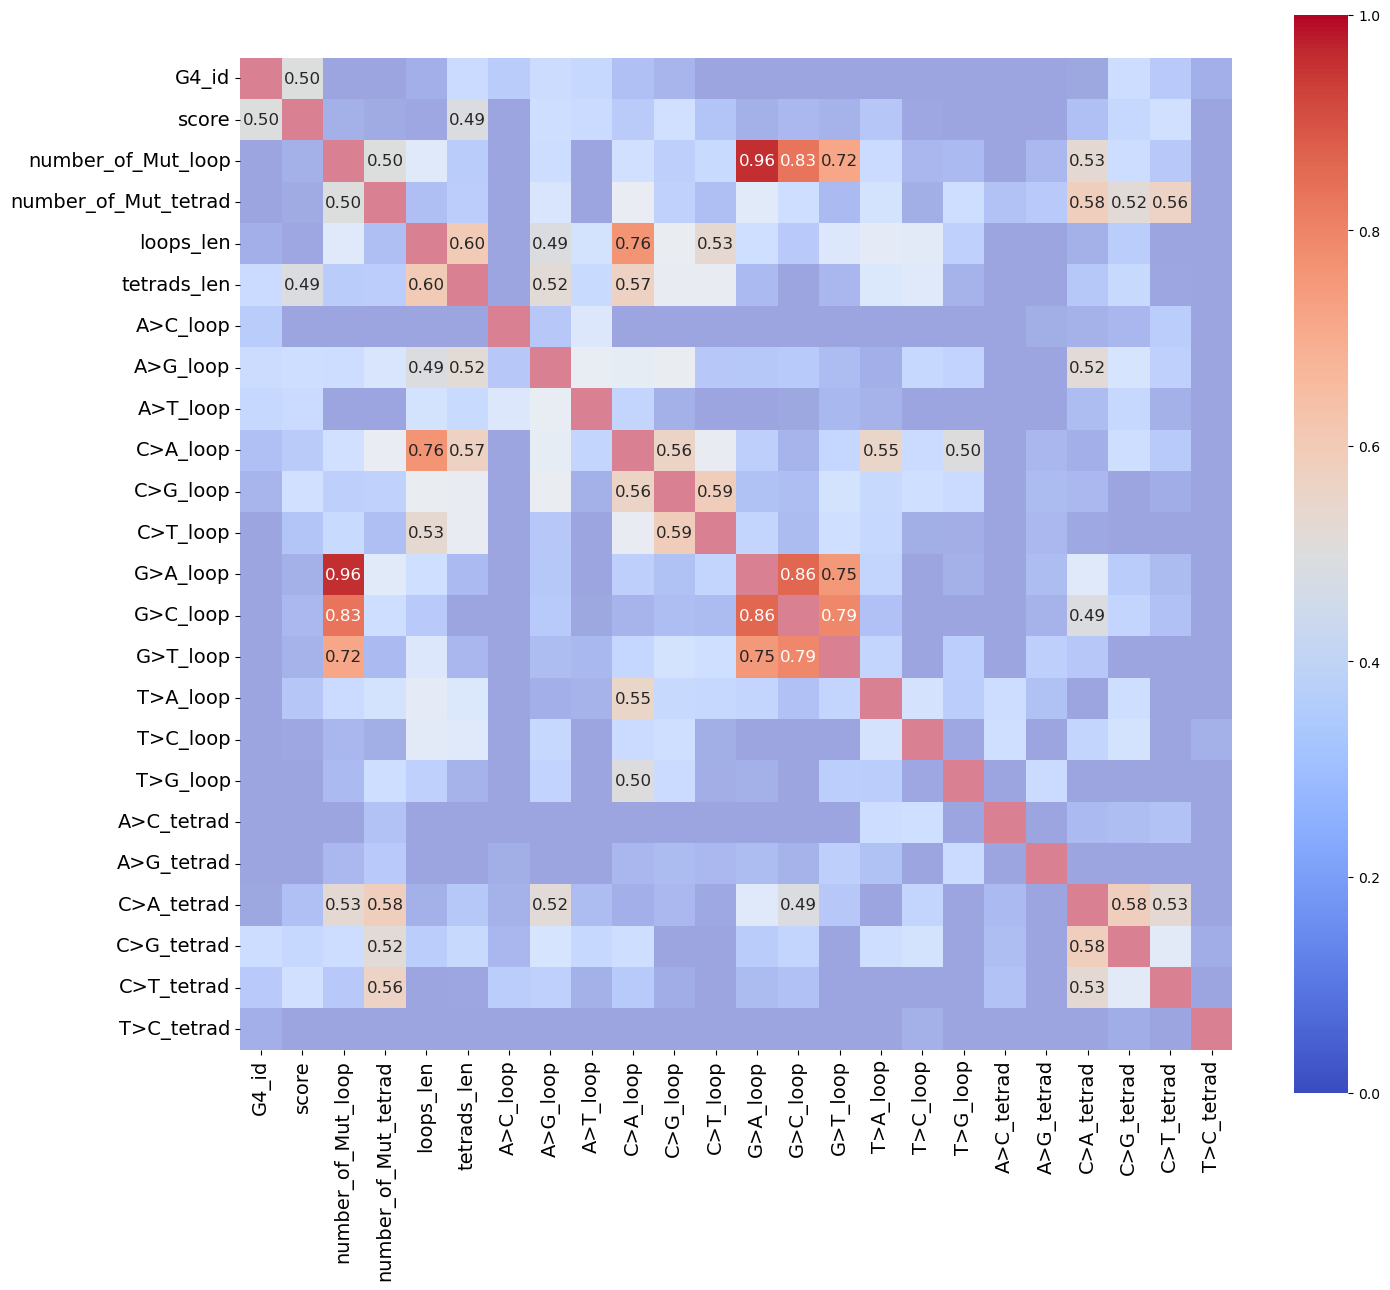

In [22]:
fig = plt.figure(figsize = (16,14))

sns.heatmap(corr, cmap='coolwarm', xticklabels=True, yticklabels=True, 
            square=True, alpha=0.5, vmin=0, vmax=1, cbar=False)

sns.heatmap(corr, cmap='coolwarm', xticklabels=True, yticklabels=True, 
            annot=True, fmt='.2f',  square=True, annot_kws={'fontsize':12},
           mask=mask, alpha=1., vmin=0, vmax=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.savefig("../data/figures/corr_pqs_score.png", bbox_inches='tight');

### Correlation rm

In [43]:
# Remove G4 with high num mut in tetrads
df_dt2_rm = df_dt2[~df_dt2['G4_id'].isin(g4_rm)]
corr_rm = df_dt2_rm.corr(method='spearman')

In [44]:
_pvals_rm = df_dt2_rm.corr(get_pval_spearman)
mask_rm = _pvals_rm > 0.01

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]),
 [Text(0, 0.5, 'G4_id'),
  Text(0, 1.5, 'score'),
  Text(0, 2.5, 'number_of_Mut_loop'),
  Text(0, 3.5, 'number_of_Mut_tetrad'),
  Text(0, 4.5, 'loops_len'),
  Text(0, 5.5, 'tetrads_len'),
  Text(0, 6.5, 'A>C_loop'),
  Text(0, 7.5, 'A>G_loop'),
  Text(0, 8.5, 'A>T_loop'),
  Text(0, 9.5, 'C>A_loop'),
  Text(0, 10.5, 'C>G_loop'),
  Text(0, 11.5, 'C>T_loop'),
  Text(0, 12.5, 'G>A_loop'),
  Text(0, 13.5, 'G>C_loop'),
  Text(0, 14.5, 'G>T_loop'),
  Text(0, 15.5, 'T>A_loop'),
  Text(0, 16.5, 'T>C_loop'),
  Text(0, 17.5, 'T>G_loop'),
  Text(0, 18.5, 'A>C_tetrad'),
  Text(0, 19.5, 'A>G_tetrad'),
  Text(0, 20.5, 'C>A_tetrad'),
  Text(0, 21.5, 'C>G_tetrad'),
  Text(0, 22.5, 'C>T_tetrad'),
  Text(0, 23.5, 'T>C_tetrad')])

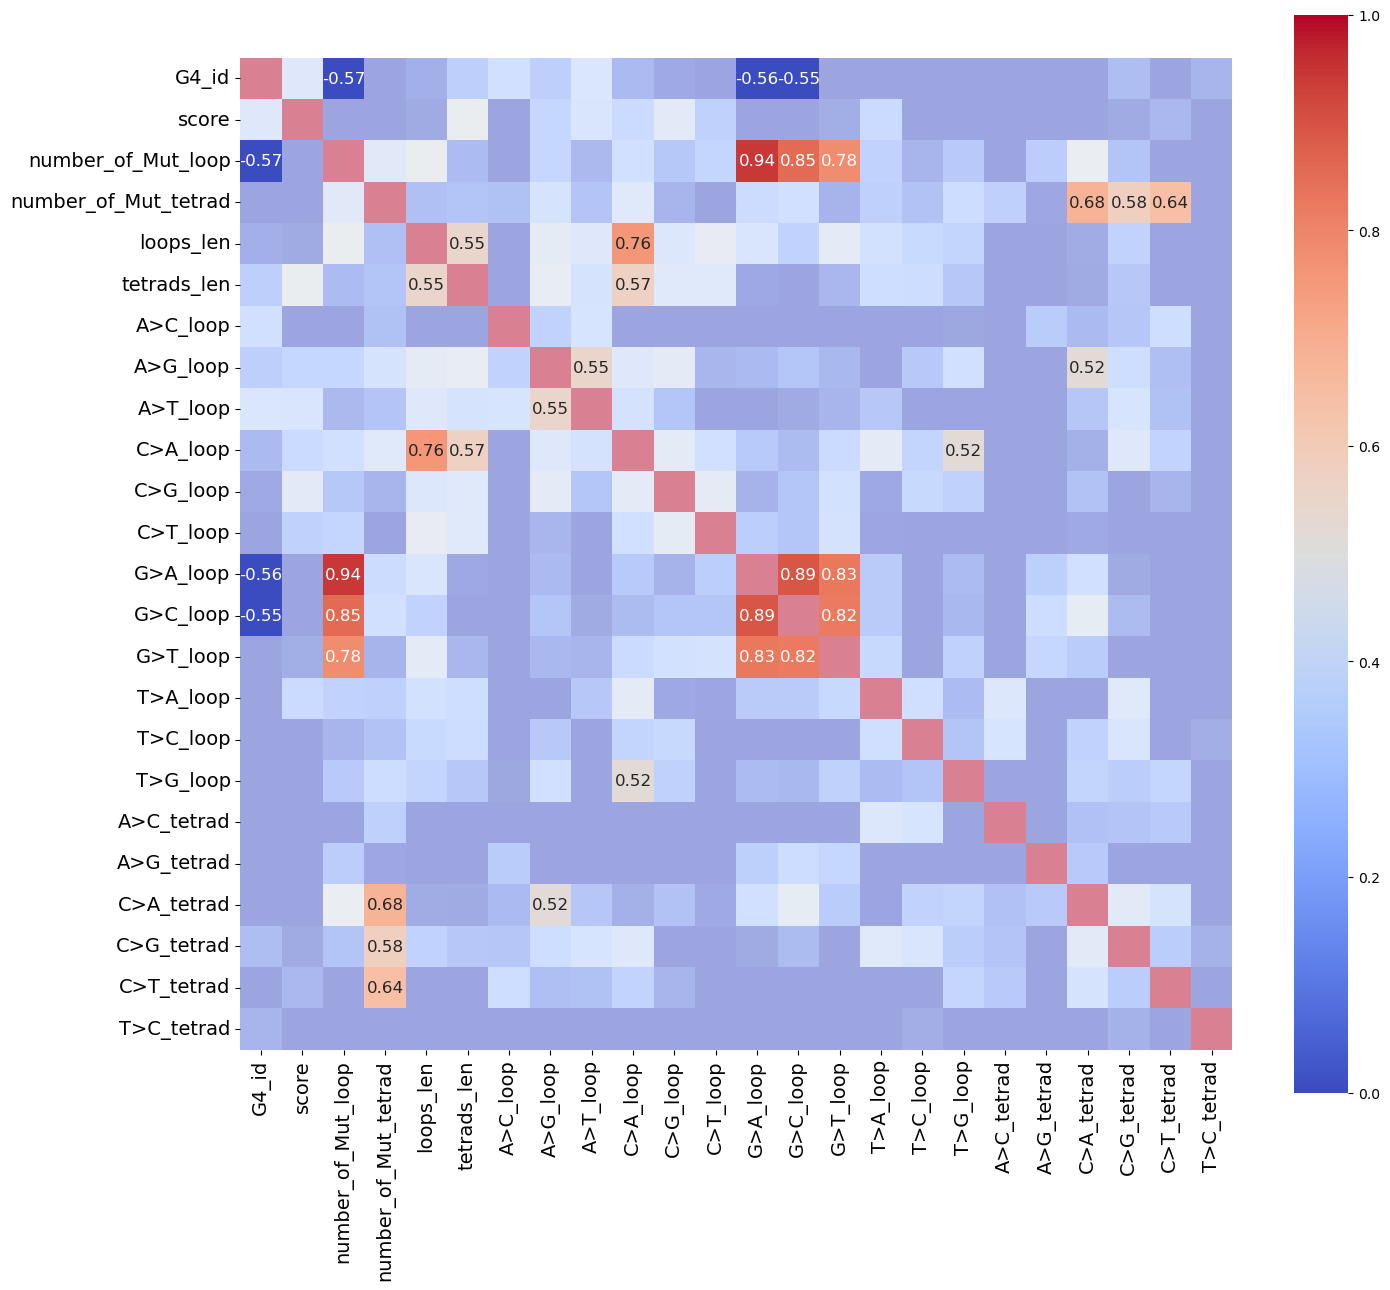

In [45]:
fig = plt.figure(figsize = (16,14))

sns.heatmap(corr_rm, cmap='coolwarm', xticklabels=True, yticklabels=True, 
            square=True, alpha=0.5, vmin=0, vmax=1, cbar=False)

sns.heatmap(corr_rm, cmap='coolwarm', xticklabels=True, yticklabels=True, 
            annot=True, fmt='.2f',  square=True, annot_kws={'fontsize':12},
           mask=mask_rm, alpha=1., vmin=0, vmax=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# fig.savefig("../data/figures/corr_pqs_score.png", bbox_inches='tight');

### Sampling

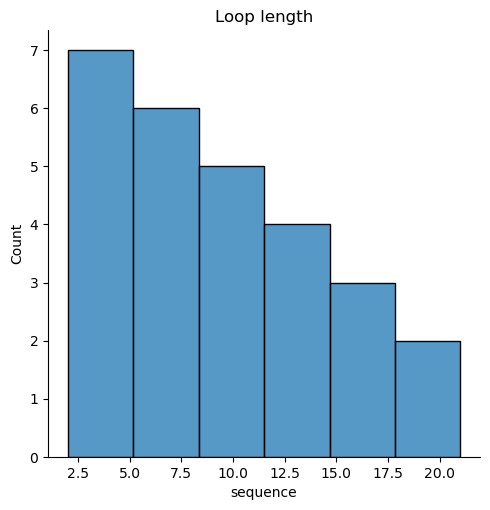

In [32]:
sns.displot(df_loop_mut_mus['sequence'].apply(lambda x: len(x))).set(title='Loop length')

In [16]:
df_loop_mut_mus[df_loop_mut_mus['sequence'].apply(lambda x: len(x)) < 10].shape

(14, 22)

In [17]:
# df_loop_cancer[df_loop_cancer['sequence'].apply(lambda x: len(x)) >= 10][['G4_id', 'side', 'positions']]

In [25]:
def sampling_data(df:pd.DataFrame, sample_size:int, frac:int, mode:str):
    all_sampling_data = []
    if mode == 'loops': 
        for row, G4_id in zip(df['positions'], 
                              df['G4_id']):
            
            for i in range(sample_size):
                sample_loops = []
                l = list(map(int, row.strip('[]').replace(' ', '').split(',')))
                frac = frac
                sample_l = sorted(sample(l, int(len(l) * frac)))
                seq = ''
                for pos in sample_l:
                    seq += refseq[pos]
                # seq = ''.join(refseq[refseq['Pos'].isin(sample_l)].Nuc.values)
                
                sample_loops.append(G4_id)
                sample_loops.append('loops')
                sample_loops.append(sample_l)
                sample_loops.append(seq)
                all_sampling_data.append(sample_loops)
    
    elif mode == 'around':
        for start, end, side, G4_id in zip(df['window_start'], 
                                     df['window_end'],
                                     df['side'],
                                     df['G4_id']):
            for i in range(sample_size):
                sample_around = []
                l = [*range(start, end)]
                frac = frac
                sample_l = sorted(sample(l, int(len(l) * frac)))
                seq = ''
                for pos in sample_l:
                    seq += refseq[pos]
                # seq = ''.join(refseq[refseq['Pos'].isin(sample_l)].Nuc.values)
                sample_around.append(G4_id)
                sample_around.append(side)
                sample_around.append(sample_l)
                sample_around.append(seq)
                all_sampling_data.append(sample_around)
    
    return all_sampling_data
    

In [19]:
def make_sampling_df(sampling_list):
    df = pd.DataFrame(data=sampling_list, columns = ['G4_id', 'side', 'positions', 'sequence'])
    nuc_count = df['sequence'].apply(lambda x: Counter(x))
    nuc_count = pd.DataFrame.from_records(nuc_count).sort_index(axis=1)
    df = df.join(nuc_count).fillna(0)
    return df

In [50]:
def collect_mut(df_mut:pd.DataFrame, df_win:pd.DataFrame, regime:str):
    if regime == '2col':
        Mut_win = []
        for window_start, window_end in zip(df_win['window_start'], df_win['window_end']):
            row = [*range(window_start, window_end)]
            Mut_win.append(str(df_mut[(df_mut['start'] == df_mut['end']) & (df_mut['start'].isin(row))].Mut.values))
    elif regime == '1col':
        Mut_win = []
        for row in df_win['positions']:
            Mut_win.append(str(df_mut[(df_mut['start'].isin(row)) & (df_mut['end'].isin(row))].Mut.values))
            
    elif regime == 'pos':
        Mut_win = []
        for i in df_win['pos_in_ref']:
            Mut_win.append(str(df_mut[(df_mut['start'] == i) & (df_mut['end'] == i)].Mut.values))
    
    Mut_win_df = pd.DataFrame(Mut_win)
    Mut_win_df[0] = Mut_win_df[0].str.findall("[A-T]>[A-T]")
    obsMutwin = pd.DataFrame.from_records(Mut_win_df[0].apply(lambda x: Counter(x))).fillna(0).sort_index(axis=1)
    df_win_mut = df_win.join(obsMutwin)
    df_win_mut['number_of_Mut'] = df_win_mut[['A>C','A>G','A>T',
                                                    'C>A','C>G','C>T',
                                                'G>A','G>C','G>T',
                                                'T>A','T>C','T>G']].sum(axis=1)
    return df_win_mut

In [33]:
refseq[2793]

'T'

In [26]:
all_sample_loops = sampling_data(df_loop_mut_mus[df_loop_mut_mus['sequence'].apply(lambda x: len(x)) >= 10], 
                                  sample_size=50, frac=0.5, mode='loops')

In [25]:
# pd.DataFrame(data=all_sample_loops)[:52]

In [52]:
df_sample_loops = collect_mut(df, make_sampling_df(all_sample_loops), regime='1col')

In [54]:
all_sample_data = sampling_data(df_10_col_mut[['G4_id', 'side', 'window_start', 'window_end']],
                                sample_size=50, frac=0.5, mode='around')

In [55]:
df_sample_10 = collect_mut(df, make_sampling_df(all_sample_data), regime='1col')

In [56]:
df_sample_10[df_sample_10['G4_id'].isin(df_sample_loops['G4_id'].unique())]

G4_id     side                            positions sequence    A    C  \
100       3    10_up       [2758, 2759, 2764, 2766, 2767]    TATTC  1.0  1.0   
101       3    10_up       [2759, 2760, 2761, 2763, 2767]    ATTAC  2.0  1.0   
102       3    10_up       [2760, 2762, 2763, 2764, 2766]    TAATT  2.0  0.0   
103       3    10_up       [2758, 2760, 2762, 2765, 2766]    TTAAT  2.0  0.0   
104       3    10_up       [2758, 2759, 2761, 2765, 2767]    TATAC  2.0  1.0   
...     ...      ...                                  ...      ...  ...  ...   
7795     27  30_down  [16144, 16145, 16146, 16150, 16151]    AGAAT  3.0  0.0   
7796     27  30_down  [16145, 16148, 16149, 16151, 16153]    GATTA  2.0  0.0   
7797     27  30_down  [16147, 16149, 16150, 16152, 16153]    CTAAA  3.0  1.0   
7798     27  30_down  [16145, 16147, 16151, 16152, 16153]    GCTAA  2.0  1.0   
7799     27  30_down  [16145, 16147, 16149, 16152, 16153]    GCTAA  2.0  1.0   

        G    T  A>C  A>G  ...  C>A  C>G  C>T  G>A  G>C  G>T  T>A  T>C  T>G  \
100   0.0  3.0  0.0  2.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  2.0  2.0  0.0   
101   0.0  2.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  3.0  3.0  0.0   
102   0.0  3.0  0.0  2.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
103   0.0  3.0  0.0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0  3.0  0.0   
104   0.0  2.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  4.0  6.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
7795  1.0  1.0  0.0  1.0  ...  0.0  0.0  0.0  4.0  1.0  2.0  0.0  1.0  0.0   
7796  1.0  2.0  0.0  1.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
7797  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   
7798  1.0  1.0  0.0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  0.0   
7799  1.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  0.0   

      number_of_Mut  
100             7.0  
101             6.0  
102             3.0  
103             5.0  
104            10.0  
...             ...  
7795            9.0  
7796            5.0  
7797            7.0  
7798            7.0  
7799            6.0  

[3750 rows x 21 columns]

In [57]:
df_sample_norm_l = add_col_to_norm_mutspec(get_norm_mutspec(df_sample_loops), df_sample_loops)

In [58]:
df_sample_norm_10 = add_col_to_norm_mutspec(get_norm_mutspec(df_sample_10), df_sample_10)

In [59]:
df_sample_norm_10[df_sample_norm_10['G4_id'] == 2]

G4_id     side  T>G       T>C  T>A       G>T       G>C       G>A  C>T  \
50        2    10_up  0.0  0.285714  0.0  0.095238  0.047619  0.285714  0.0   
51        2    10_up  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
52        2    10_up  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
53        2    10_up  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
54        2    10_up  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
...     ...      ...  ...       ...  ...       ...       ...       ...  ...   
6595      2  30_down  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
6596      2  30_down  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
6597      2  30_down  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
6598      2  30_down  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
6599      2  30_down  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   

      C>G  C>A  A>T       A>G  A>C  
50    0.0  0.0  0.0  0.285714  0.0  
51    0.0  0.0  0.0  0.000000  0.0  
52    0.0  0.0  0.0  0.000000  0.0  
53    0.0  0.0  0.0  0.000000  0.0  
54    0.0  0.0  0.0  0.000000  0.0  
...   ...  ...  ...       ...  ...  
6595  0.0  0.0  0.0  0.000000  0.0  
6596  0.0  0.0  0.0  0.000000  0.0  
6597  0.0  0.0  0.0  0.000000  0.0  
6598  0.0  0.0  0.0  0.000000  0.0  
6599  0.0  0.0  0.0  0.000000  0.0  

[300 rows x 14 columns]

In [60]:
df_sample_10[df_sample_10['G4_id'] == 2]

G4_id     side                       positions sequence    A    C    G  \
50        2    10_up  [1085, 1086, 1087, 1089, 1090]    CACCT  1.0  3.0  0.0   
51        2    10_up  [1086, 1087, 1089, 1093, 1094]    ACCAC  2.0  3.0  0.0   
52        2    10_up  [1085, 1088, 1089, 1090, 1091]    CTCTG  0.0  2.0  1.0   
53        2    10_up  [1086, 1088, 1090, 1091, 1092]    ATTGA  2.0  0.0  1.0   
54        2    10_up  [1085, 1089, 1090, 1092, 1093]    CCTAA  2.0  2.0  0.0   
...     ...      ...                             ...      ...  ...  ...  ...   
6595      2  30_down  [1139, 1141, 1142, 1143, 1146]    TAATA  3.0  0.0  0.0   
6596      2  30_down  [1138, 1139, 1141, 1143, 1145]    ATATA  3.0  0.0  0.0   
6597      2  30_down  [1142, 1143, 1144, 1146, 1147]    ATCAA  3.0  1.0  0.0   
6598      2  30_down  [1140, 1143, 1145, 1146, 1147]    ATAAA  4.0  0.0  0.0   
6599      2  30_down  [1138, 1139, 1142, 1145, 1146]    ATAAA  4.0  0.0  0.0   

        T  A>C  A>G  ...  C>A  C>G  C>T   G>A  G>C  G>T  T>A  T>C  T>G  \
50    1.0  0.0  2.0  ...  2.0  1.0  6.0   0.0  0.0  0.0  0.0  2.0  0.0   
51    0.0  1.0  5.0  ...  1.0  1.0  4.0   0.0  0.0  0.0  0.0  2.0  0.0   
52    2.0  0.0  1.0  ...  2.0  1.0  4.0   0.0  0.0  0.0  0.0  5.0  0.0   
53    2.0  0.0  0.0  ...  3.0  2.0  8.0  23.0  0.0  0.0  0.0  3.0  0.0   
54    1.0  0.0  2.0  ...  1.0  0.0  2.0  23.0  0.0  0.0  0.0  2.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...   ...  ...  ...  ...  ...  ...   
6595  2.0  0.0  0.0  ...  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
6596  2.0  0.0  0.0  ...  3.0  2.0  0.0   0.0  0.0  0.0  0.0  1.0  0.0   
6597  1.0  0.0  0.0  ...  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
6598  1.0  0.0  0.0  ...  3.0  2.0  0.0   0.0  0.0  0.0  0.0  3.0  0.0   
6599  1.0  0.0  0.0  ...  3.0  2.0  0.0   0.0  0.0  0.0  0.0  1.0  0.0   

      number_of_Mut  
50             13.0  
51             14.0  
52             13.0  
53             39.0  
54             30.0  
...             ...  
6595            0.0  
6596            6.0  
6597            0.0  
6598            8.0  
6599            6.0  

[300 rows x 21 columns]

In [61]:
df_sample_norm_concat = pd.concat([df_sample_norm_l, 
                                   df_sample_norm_10[df_sample_norm_10['G4_id'].isin(df_sample_norm_l['G4_id'].unique())]]) \
    .reset_index(drop=True)

In [62]:
df_sample_norm_concat.columns

Index(['G4_id', 'side', 'T>G', 'T>C', 'T>A', 'G>T', 'G>C', 'G>A', 'C>T', 'C>G',
       'C>A', 'A>T', 'A>G', 'A>C'],
      dtype='object')

In [63]:
df_sample_norm_concat

G4_id     side  T>G       T>C       T>A       G>T  G>C       G>A  \
0         3    loops  0.0  0.010601  0.000000  0.000000  0.0  0.000000   
1         3    loops  0.0  0.000000  0.000000  0.009804  0.0  0.029412   
2         3    loops  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
3         3    loops  0.0  0.020690  0.000000  0.000000  0.0  0.000000   
4         3    loops  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
...     ...      ...  ...       ...       ...       ...  ...       ...   
4395     27  30_down  0.0  0.040000  0.000000  0.000000  0.0  0.000000   
4396     27  30_down  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
4397     27  30_down  0.0  0.000000  0.200000  0.000000  0.0  0.000000   
4398     27  30_down  0.0  0.100000  0.300000  0.000000  0.0  0.000000   
4399     27  30_down  0.0  0.000000  0.333333  0.000000  0.0  0.000000   

           C>T       C>G       C>A       A>T       A>G  A>C  
0     0.932862  0.021201  0.021201  0.000000  0.014134  0.0  
1     0.862745  0.019608  0.019608  0.009804  0.049020  0.0  
2     0.000000  0.000000  0.000000  0.000000  0.000000  0.0  
3     0.910345  0.020690  0.020690  0.006897  0.020690  0.0  
4     0.789474  0.052632  0.052632  0.026316  0.078947  0.0  
...        ...       ...       ...       ...       ...  ...  
4395  0.480000  0.120000  0.240000  0.000000  0.120000  0.0  
4396  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  
4397  0.000000  0.000000  0.000000  0.000000  0.800000  0.0  
4398  0.000000  0.000000  0.000000  0.000000  0.600000  0.0  
4399  0.000000  0.000000  0.000000  0.000000  0.666667  0.0  

[4400 rows x 14 columns]

In [64]:
mutations = ['T>G', 'T>C', 'T>A', 'G>T', 'G>C', 'G>A', 'C>T', 'C>G',
       'C>A', 'A>T', 'A>G', 'A>C']

In [65]:
df_sample_norm_concat['side'].nunique() * df_sample_norm_concat['G4_id'].nunique() * len(mutations)

1092

In [79]:
df_sample_norm_concat['G4_id'].nunique()

13

In [66]:
dct = {}
for G4_id in df_sample_norm_concat['G4_id'].unique():
    for side in df_sample_norm_concat['side'].unique():
        for mut in mutations:
            dct[f"sample_{G4_id}_{side}_{mut}"] = df_sample_norm_concat[(df_sample_norm_concat['G4_id'] == G4_id) & 
                                                                        (df_sample_norm_concat['side'] == side)][mut]

In [67]:
# for G4_id in df_sample_norm_concat['G4_id'].unique():
#     for mut in mutations:
#         print(G4_id, mut, '\n', stats.kruskal(dct[f"sample_{G4_id}_loops_{mut}"], dct[f"sample_{G4_id}_15_up_{mut}"], dct[f"sample_{G4_id}_15_down_{mut}"], dct[f"sample_{G4_id}_30_up_{mut}"], dct[f"sample_{G4_id}_30_down_{mut}"], dct[f"sample_{G4_id}_45_up_{mut}"],dct[f"sample_{G4_id}_45_down_{mut}"])[1])

In [68]:
df_sample_norm_concat['G4_id'].unique()

array([ 3,  5,  6, 10, 11, 14, 15, 17, 18, 22, 23, 25, 27], dtype=int64)

In [69]:
df_mu_10 = []
for G4_id in df_sample_norm_concat['G4_id'].unique():
    
    for mut in mutations:
        a_up = []
        a_down = []
        if (dct[f"sample_{G4_id}_10_up_{mut}"].empty == True) | (dct[f"sample_{G4_id}_10_down_{mut}"].empty == True):
            break
        else:
            # print(G4_id, mut, '\n',
            #   'loop+15up', stats.mannwhitneyu(dct[f"sample_{G4_id}_loops_{mut}"], dct[f"sample_{G4_id}_15_up_{mut}"])[1], '\n', \
            #   'loop+15down', stats.mannwhitneyu(dct[f"sample_{G4_id}_loops_{mut}"], dct[f"sample_{G4_id}_15_down_{mut}"])[1], '\n')
            a_up += G4_id, mut, \
            'loop+10up', stats.mannwhitneyu(dct[f"sample_{G4_id}_loops_{mut}"], dct[f"sample_{G4_id}_10_up_{mut}"])[1]
            a_down += G4_id, mut, \
            'loop+10down', stats.mannwhitneyu(dct[f"sample_{G4_id}_loops_{mut}"], dct[f"sample_{G4_id}_10_down_{mut}"])[1]
            
            df_mu_10.append(a_up)
            df_mu_10.append(a_down)

In [71]:
df_mu_10 = pd.DataFrame(df_mu_10, columns=['G4_id', 'mut', 'side', 'p_val'])

In [72]:
df_mu_10.head()

G4_id  mut         side         p_val
0      3  T>G    loop+10up  1.000000e+00
1      3  T>G  loop+10down  1.000000e+00
2      3  T>C    loop+10up  2.149524e-04
3      3  T>C  loop+10down  4.231976e-02
4      3  T>A    loop+10up  7.740574e-08

In [73]:
df_mu_10.G4_id.nunique()

12

In [74]:
mut_per_id = df_mu_10[df_mu_10['p_val'] < 0.05].groupby('G4_id').agg({'mut': 'value_counts'}).rename(columns={'mut':'count'})

In [75]:
mut_per_id.head()

count
G4_id mut       
3     A>G      2
      A>T      2
      T>C      2
      G>A      2
      C>T      2

In [76]:
mut_per_id[mut_per_id['count'] > 1].reset_index().G4_id.value_counts()

G4_id
3     7
5     6
6     6
11    5
14    5
22    5
23    5
27    5
15    4
18    4
17    3
10    2
Name: count, dtype: int64

In [77]:
mut_per_id[mut_per_id['count'] > 1].reset_index().mut.value_counts()

mut
G>A    9
A>G    7
G>C    6
G>T    6
A>T    4
C>T    4
C>A    4
T>A    4
T>G    4
T>C    3
C>G    3
A>C    3
Name: count, dtype: int64

In [49]:
# на семплированных данных
# только у половины Г4 (55% (9 всего 12шт)) G>A значимо отличается от окружения +-10bp

In [84]:
mut_per_id.reset_index().mut.value_counts()

mut
G>T    12
A>G    11
G>A    11
C>T    11
G>C    11
A>T    10
T>C    10
C>A    10
C>G     9
T>A     9
T>G     5
A>C     5
Name: count, dtype: int64

In [85]:
# на семплированных данных
    # у большей части Г4 (96% (12, всего 12шт)) G>T значимо отличается хотя бы с одной стороны окружения +-10bp

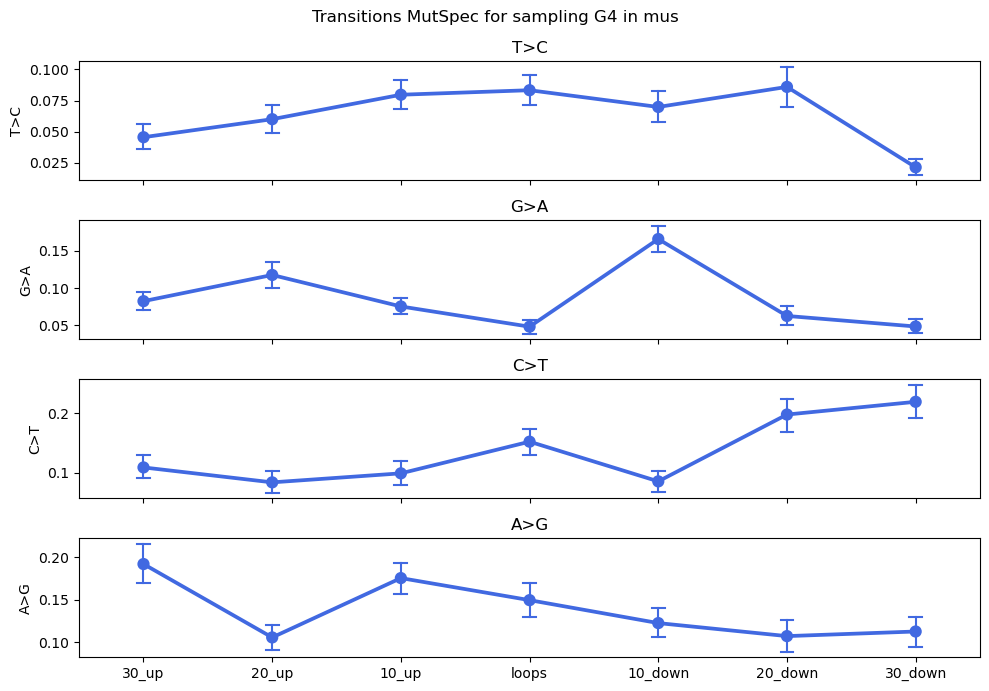

In [104]:
fig, axs = plt.subplots(4, sharex=True,  figsize=(10, 7))
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = ['30_up', '20_up', '10_up', 'loops', '10_down', '20_down', '30_down']

for i, mutation in enumerate(mutations):
    row = i % 4
    sns.pointplot(data=df_sample_norm_concat, 
                 x=df_sample_norm_concat['side'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)


plt.suptitle('Transitions MutSpec for sampling G4 in mus')
plt.tight_layout()
plt.show()

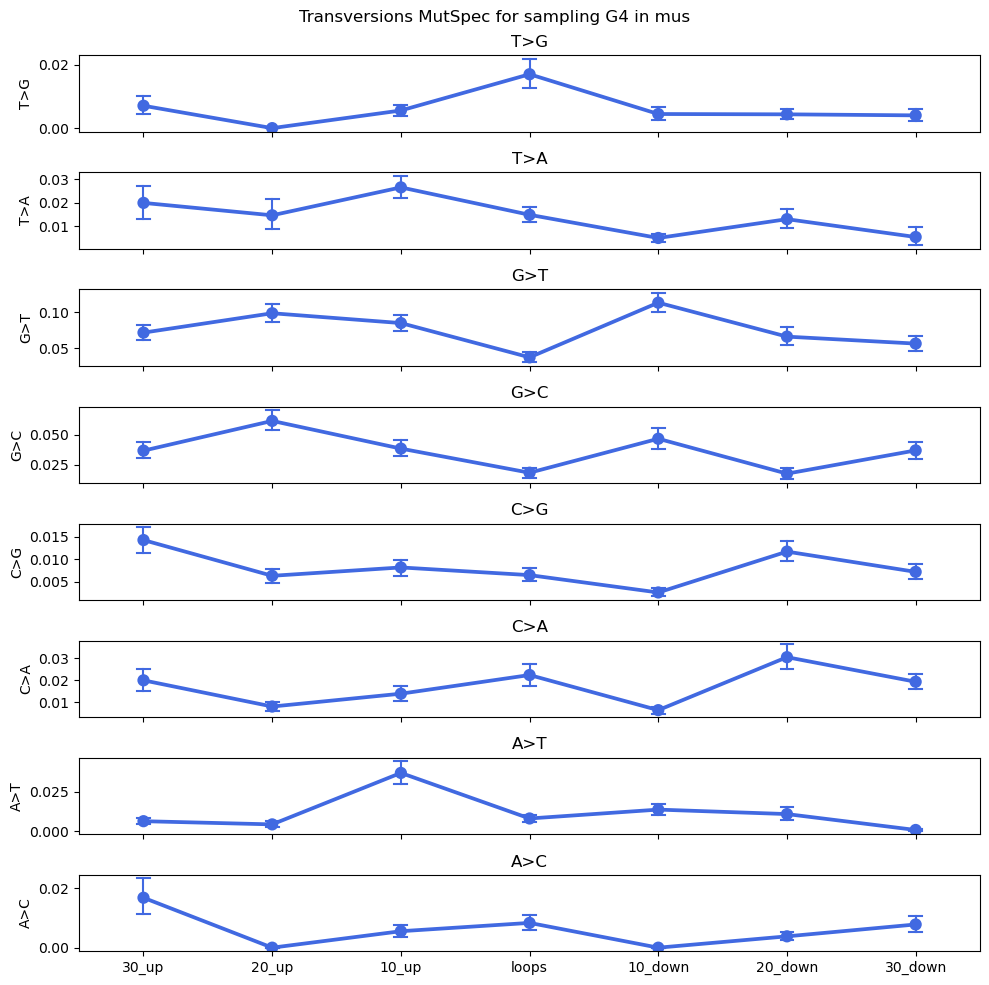

In [102]:
fig, axs = plt.subplots(8, sharex=True, figsize=(10, 10))
mutations = ['T>G', 'T>A', 'G>T', 'G>C', 'C>G', 'C>A', 'A>T', 'A>C']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = ['30_up', '20_up', '10_up', 'loops', '10_down', '20_down', '30_down']

for i, mutation in enumerate(mutations):
    row = i % 8
    sns.pointplot(data=df_sample_norm_concat, 
                 x=df_sample_norm_concat['side'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)

plt.suptitle('Transversions MutSpec for sampling G4 in mus')
plt.tight_layout()
plt.show()

#### Transitions for each G4, sampling data

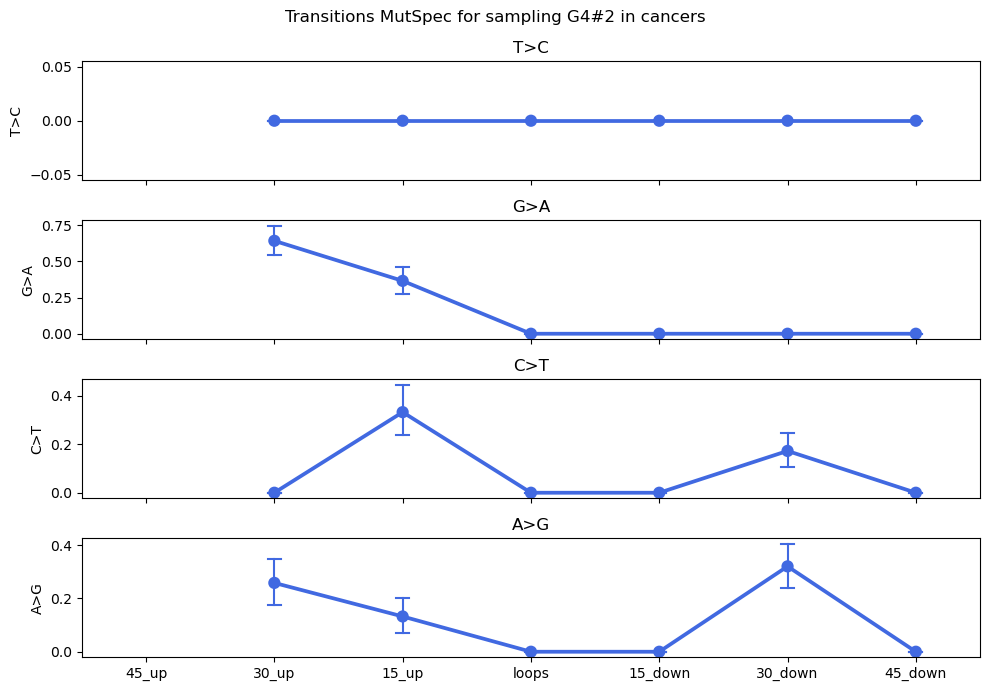

In [58]:
fig, axs = plt.subplots(4, sharex=True,  figsize=(10, 7))
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = ['45_up', '30_up', '15_up', 'loops', '15_down', '30_down', '45_down']

for i, mutation in enumerate(mutations):
    row = i % 4
    sns.pointplot(data=df_sample_norm_concat[df_sample_norm_concat['G4_id']==2], 
                 x=df_sample_norm_concat[df_sample_norm_concat['G4_id']==2]['side'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)


plt.suptitle('Transitions MutSpec for sampling G4#2 in cancers')
plt.tight_layout()
plt.show()

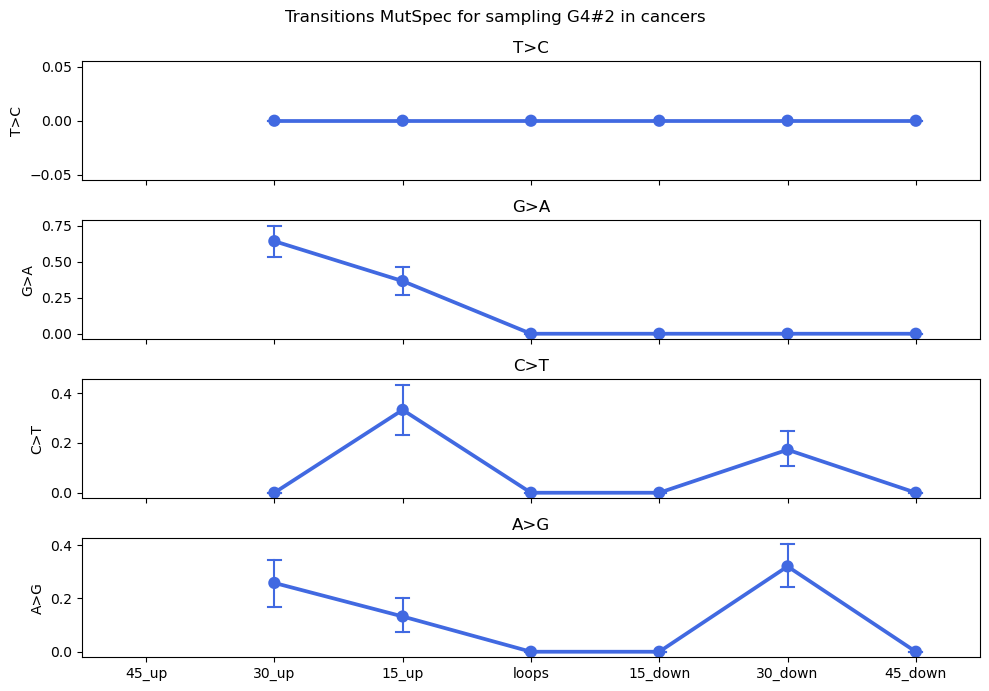

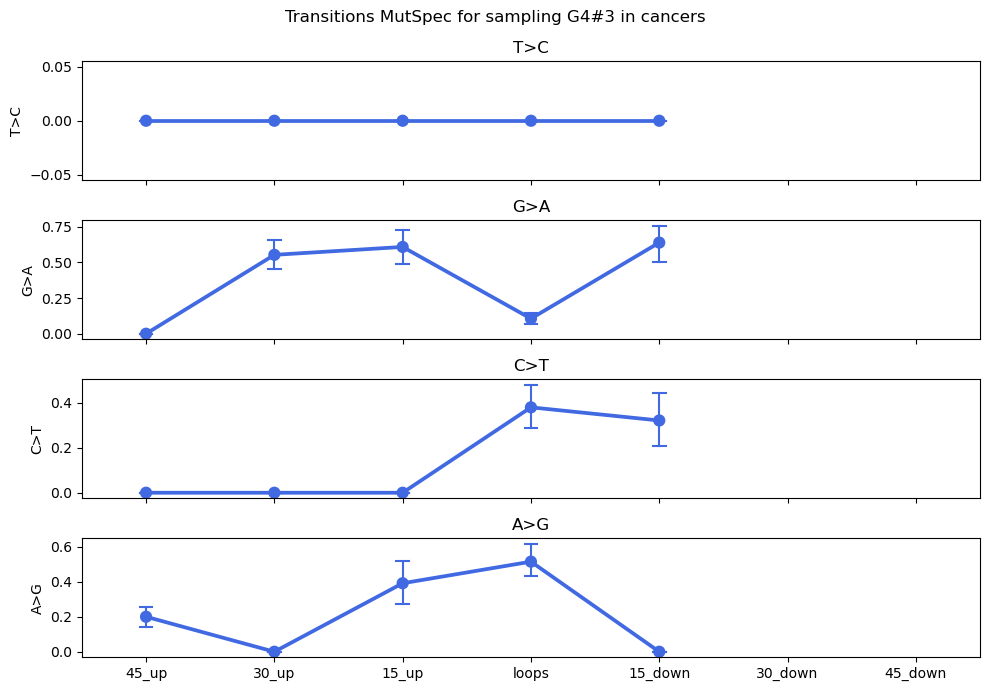

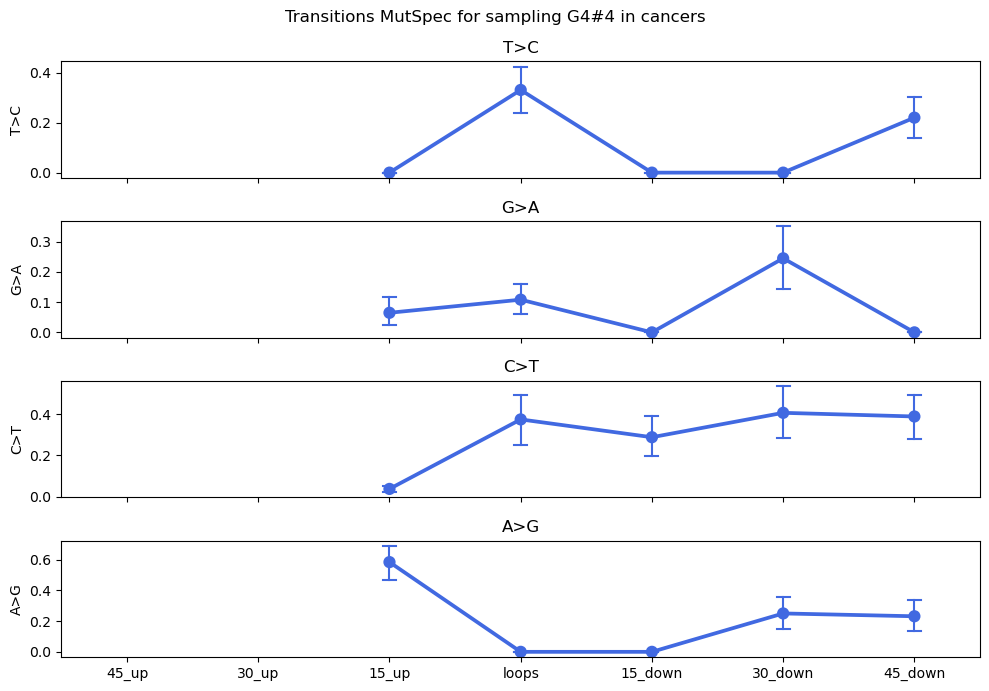

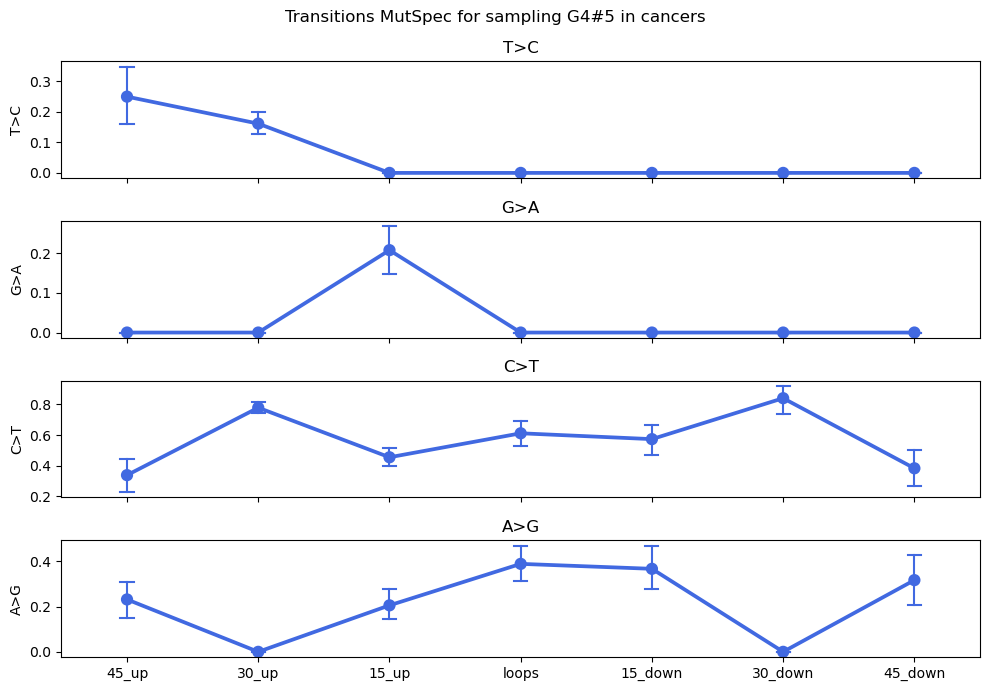

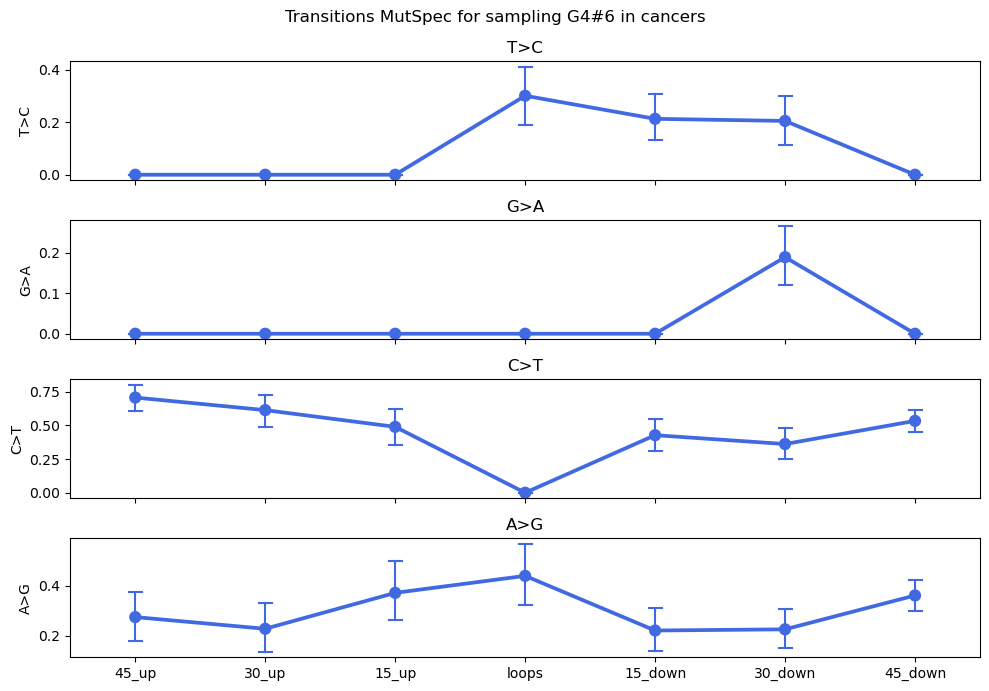

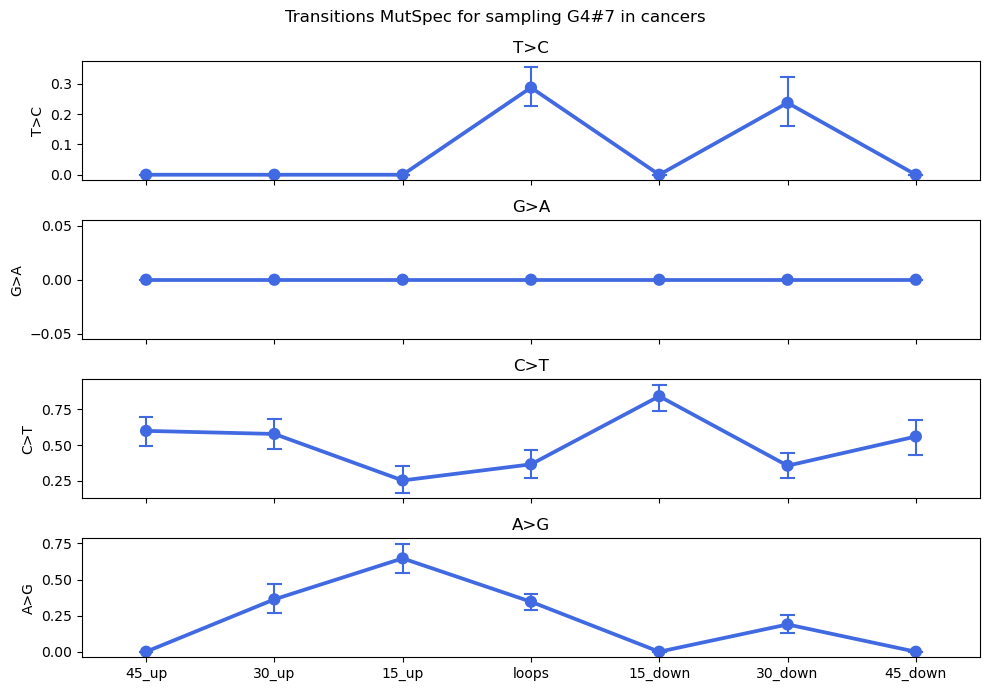

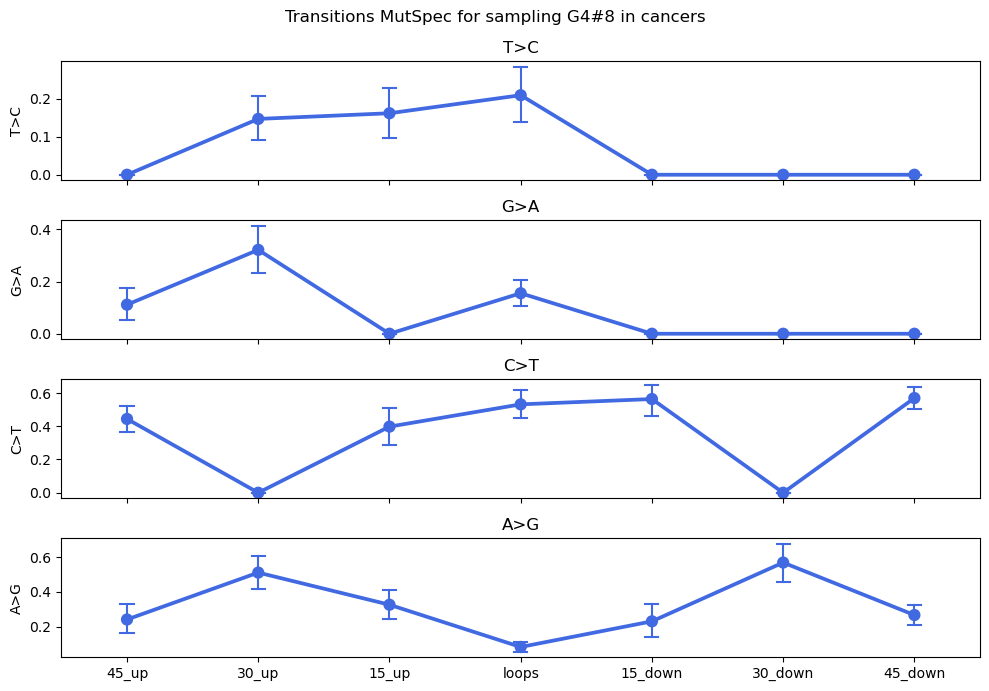

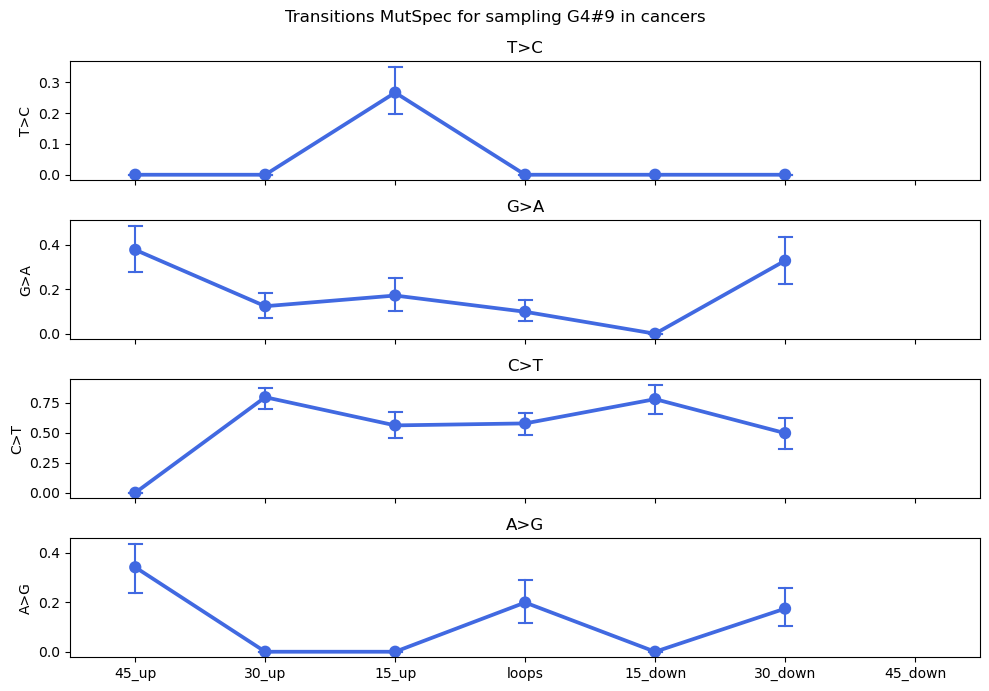

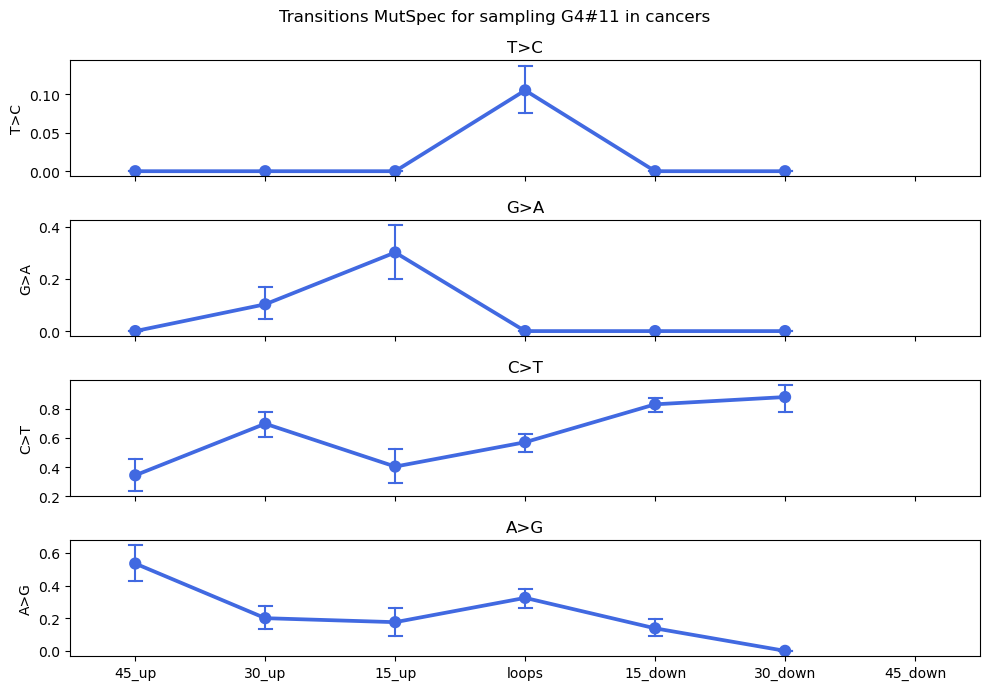

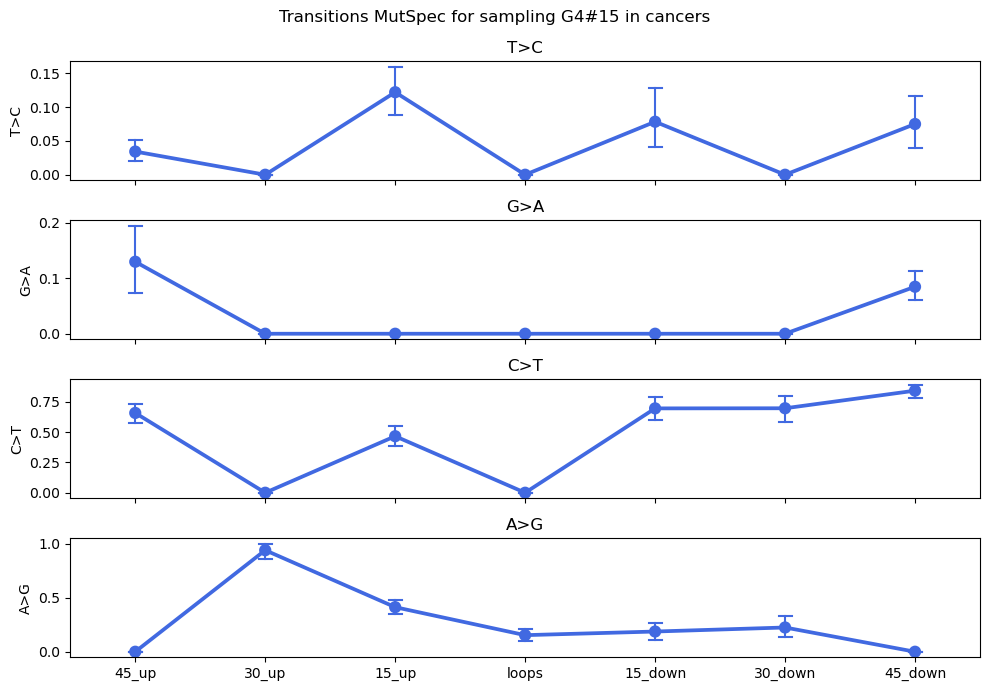

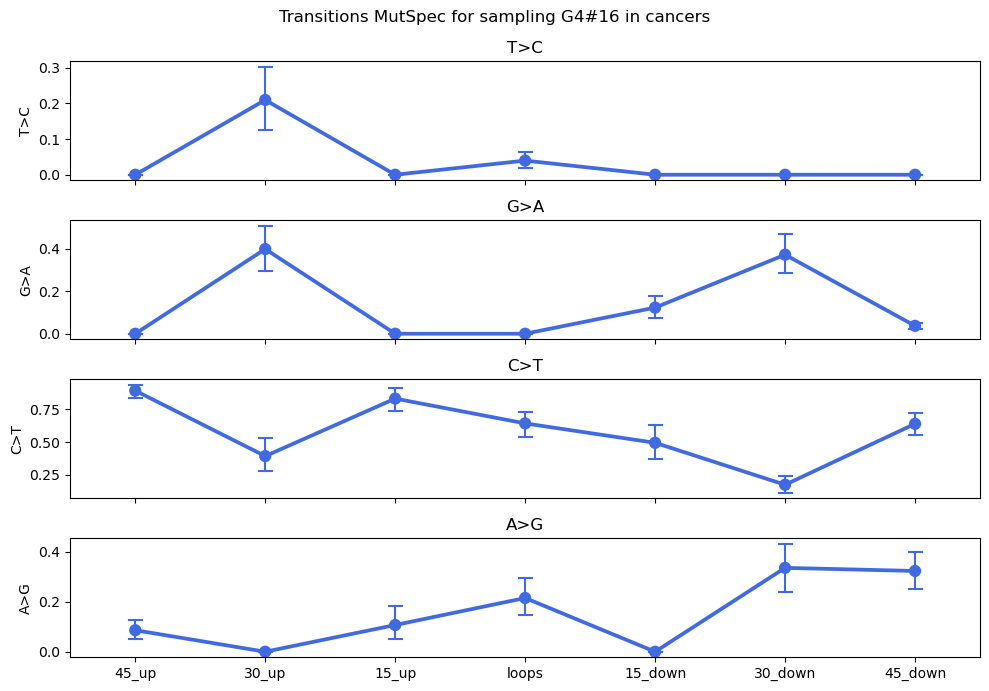

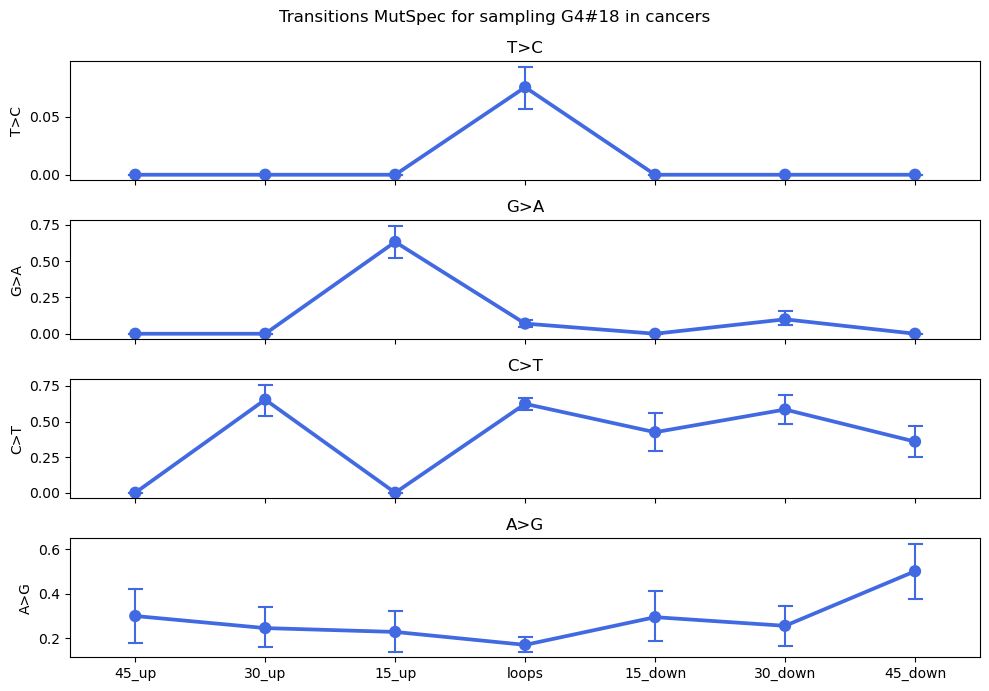

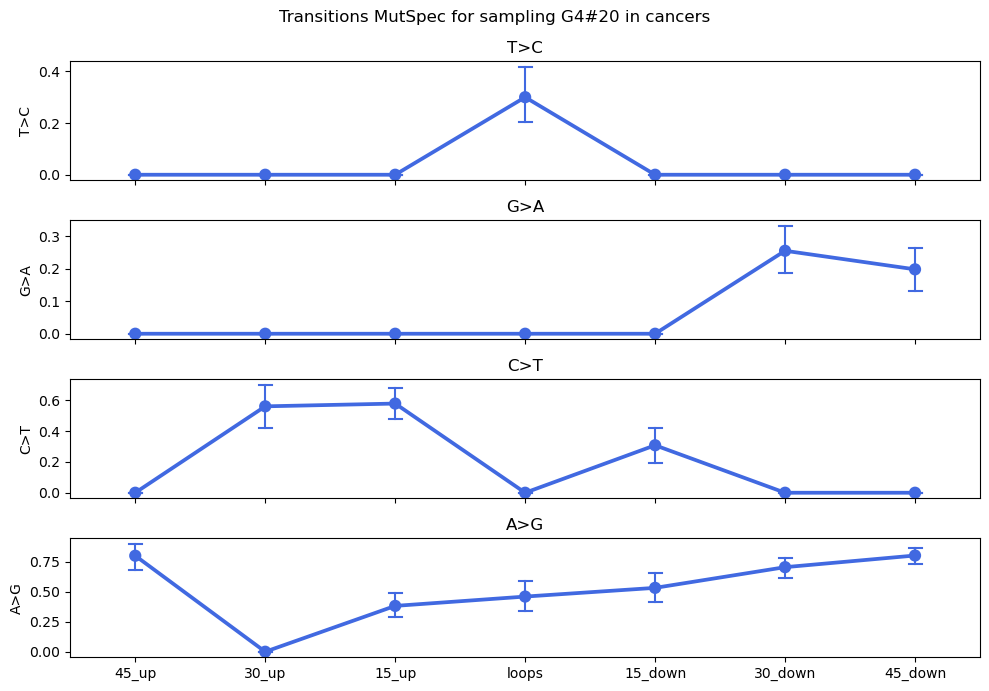

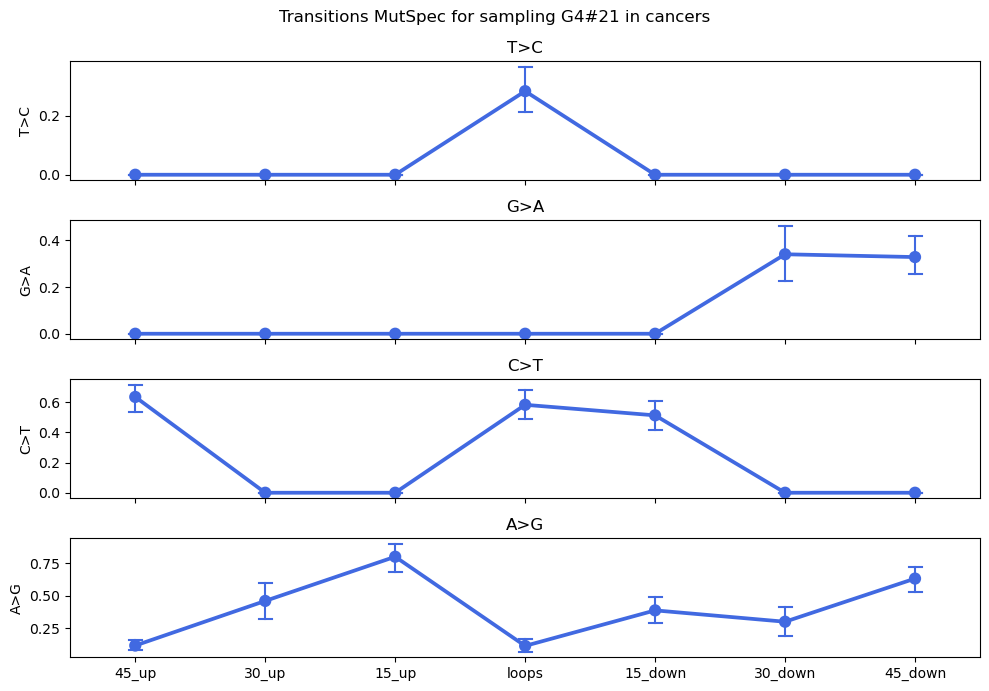

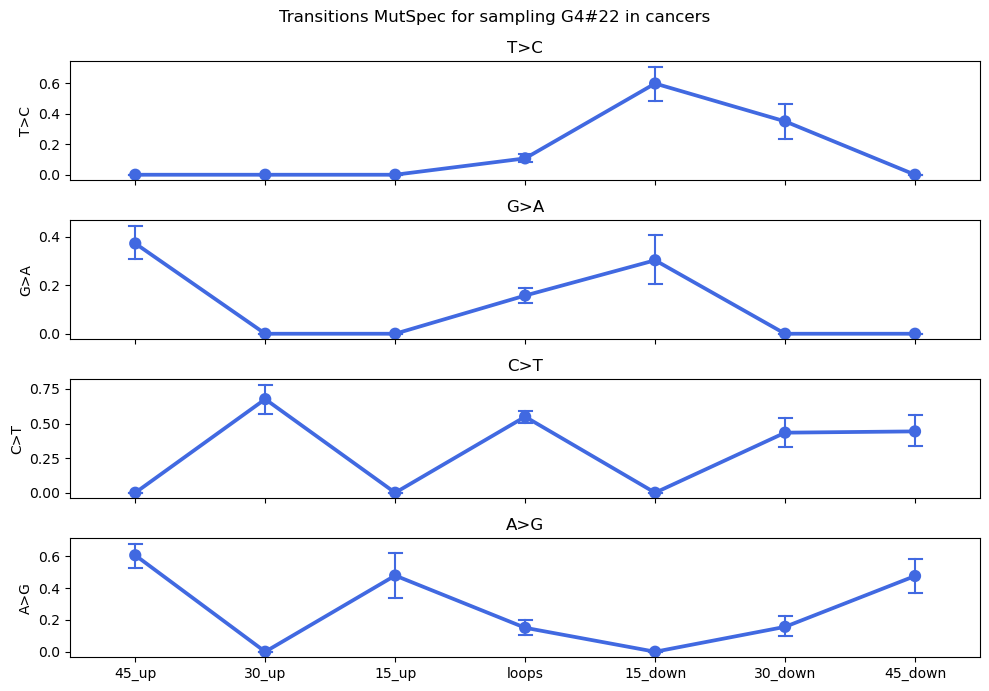

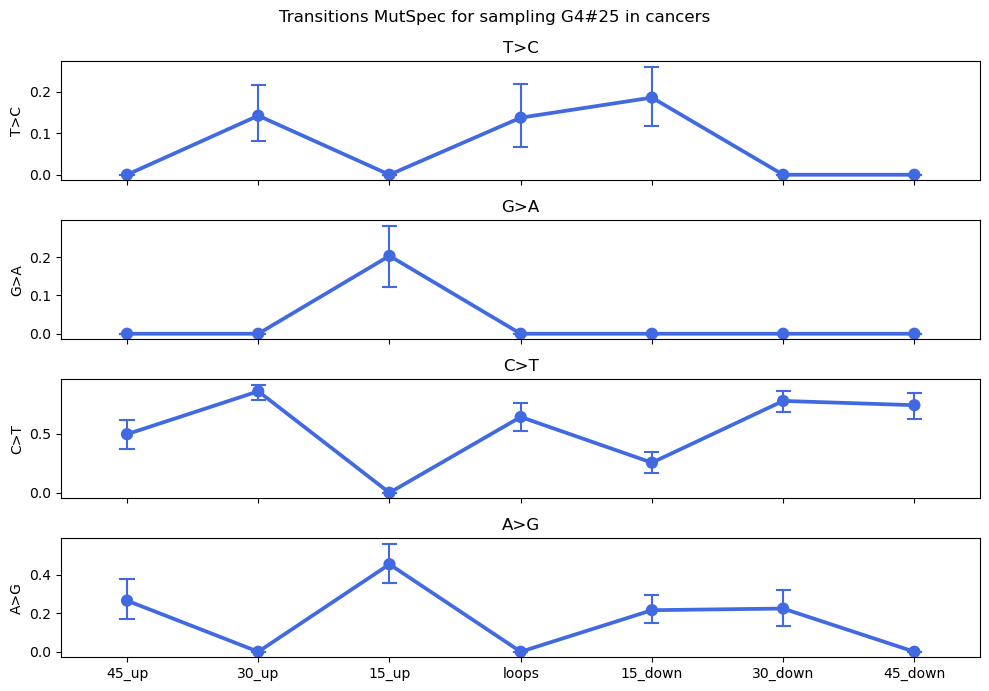

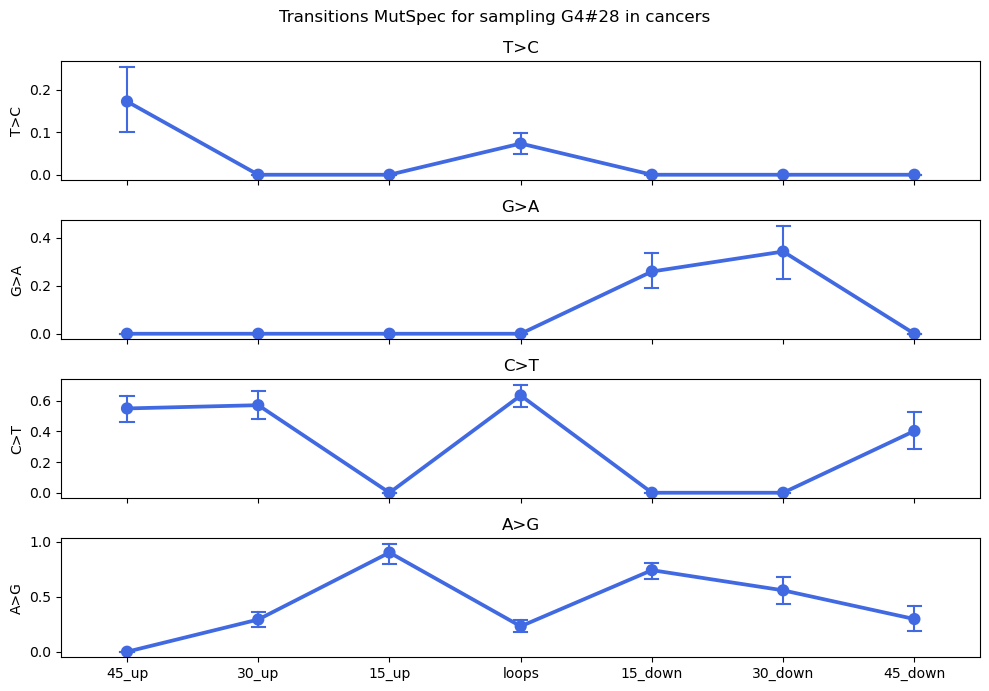

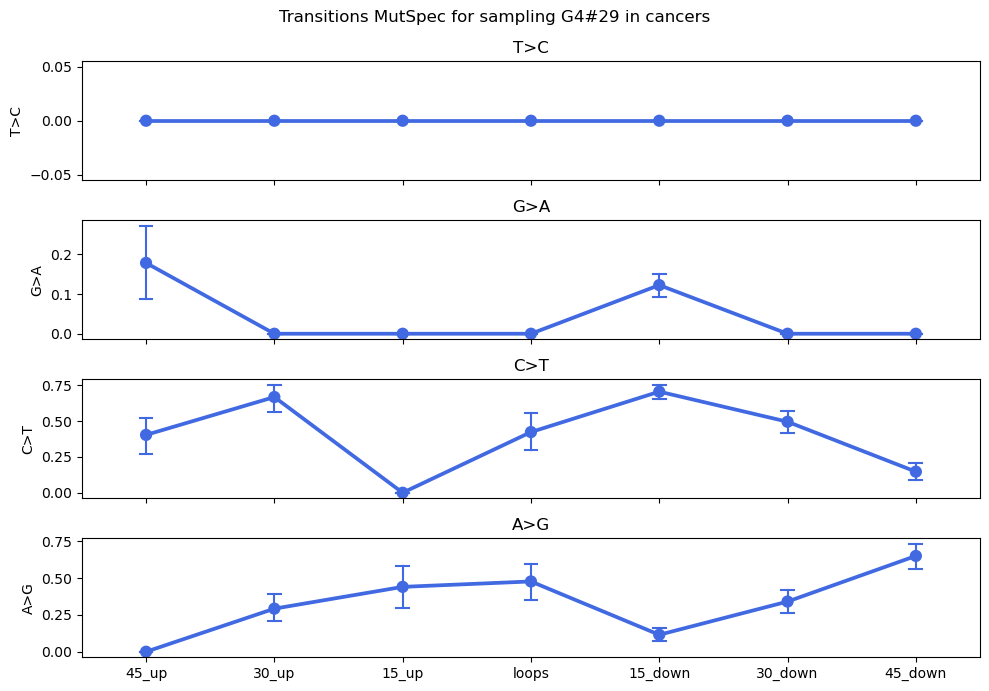

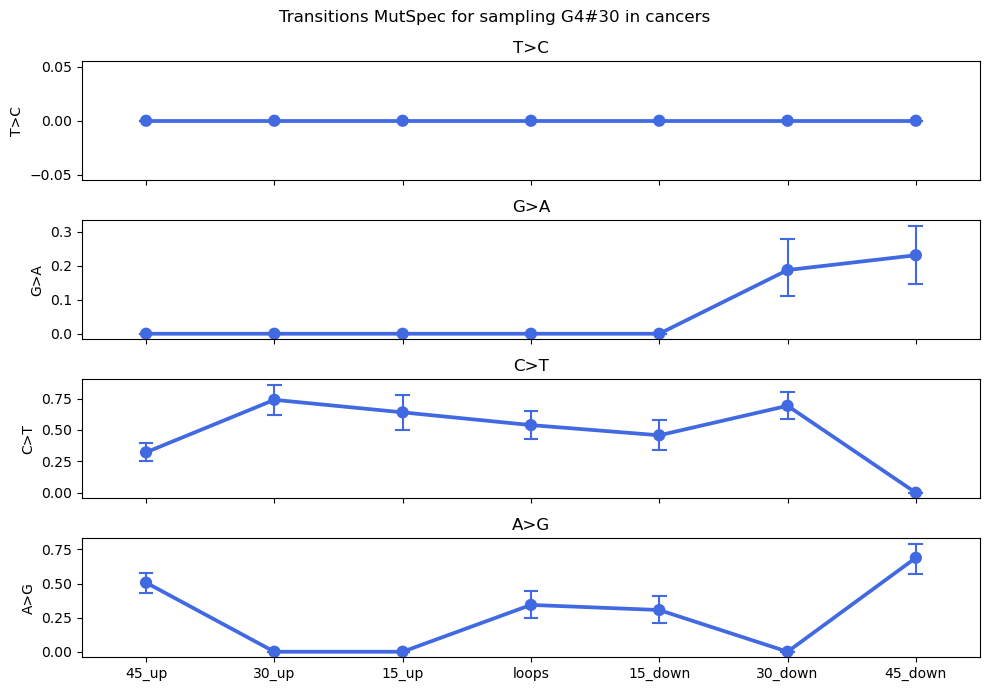

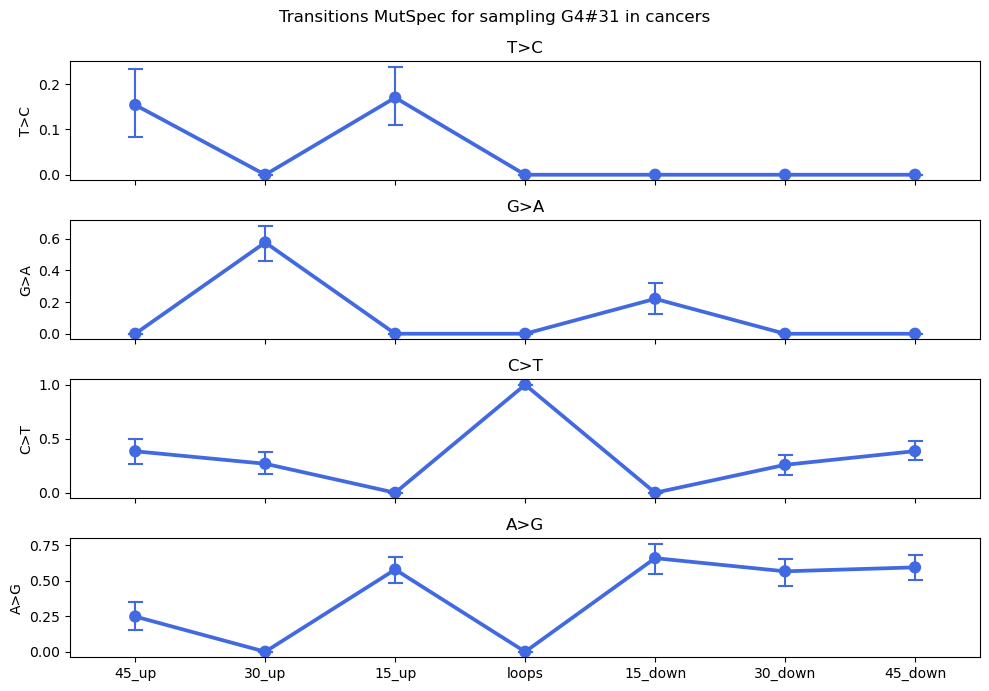

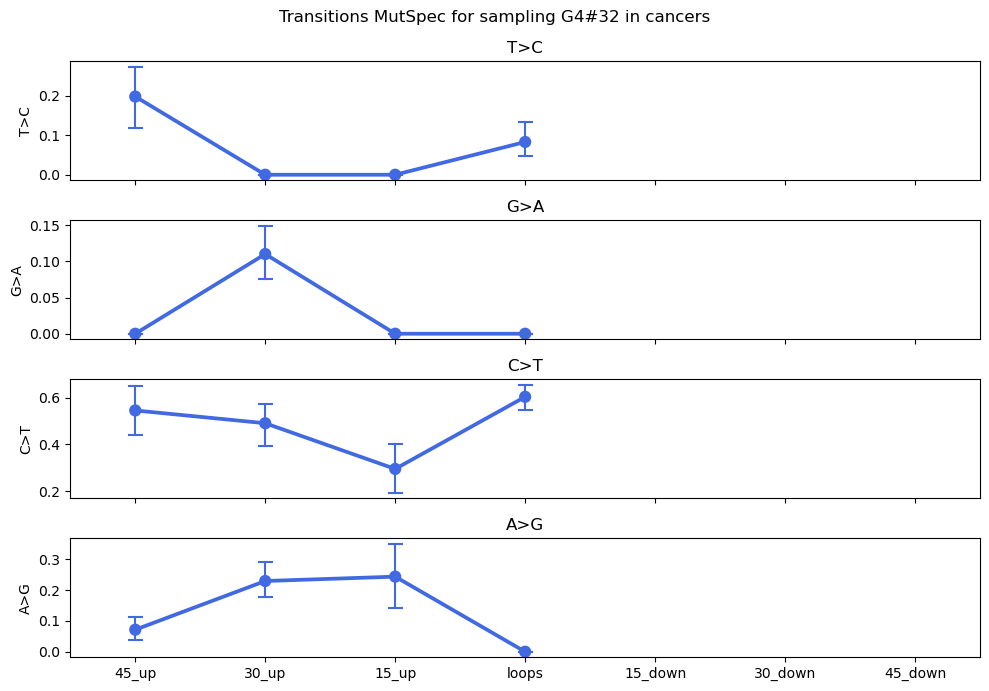

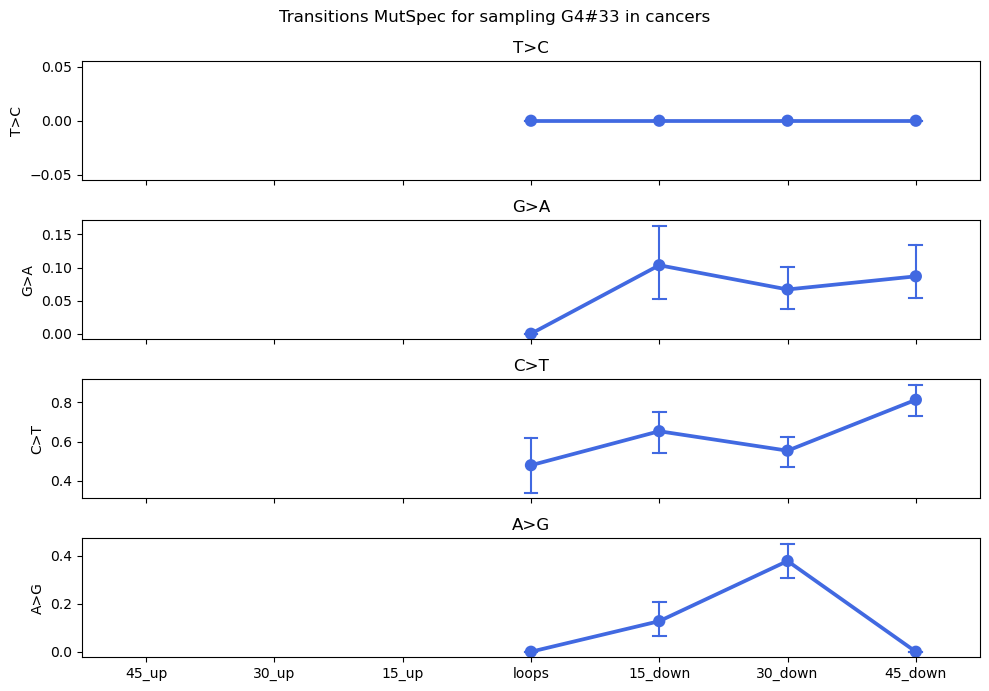

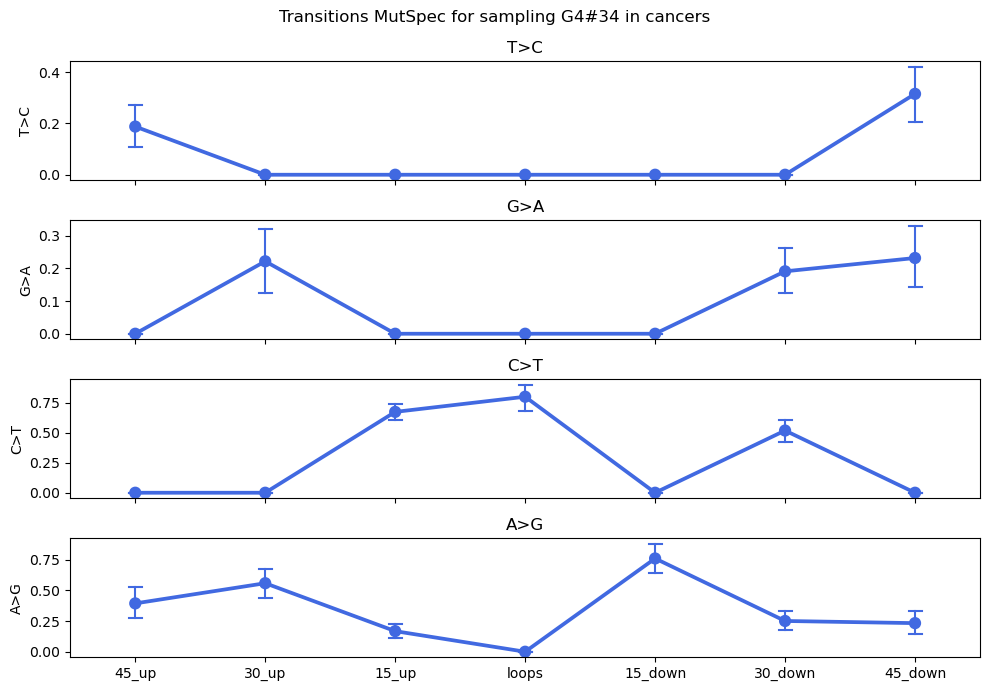

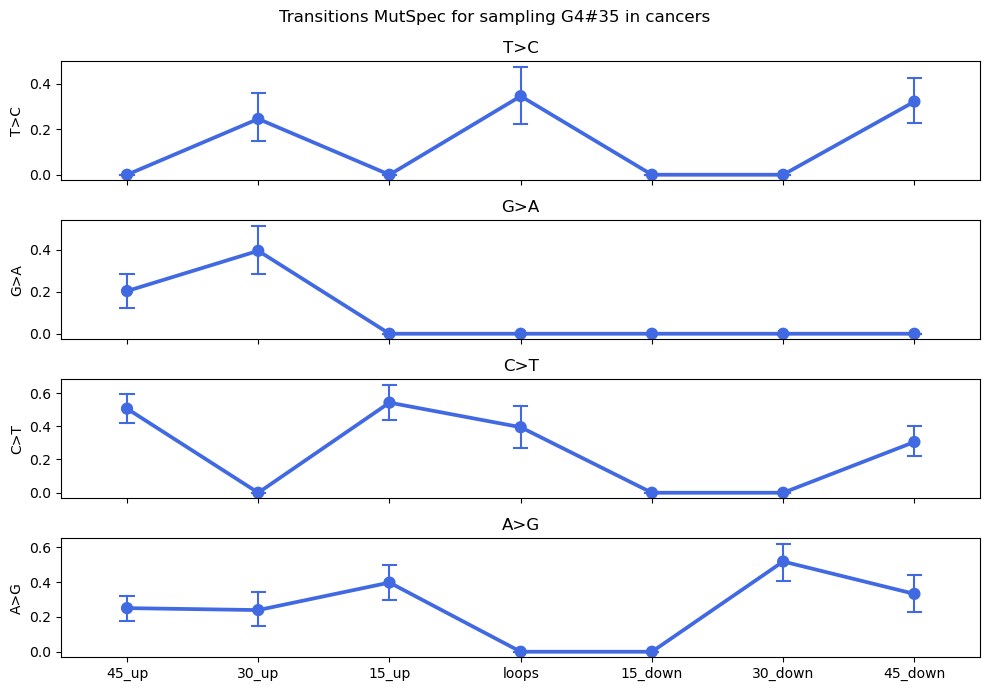

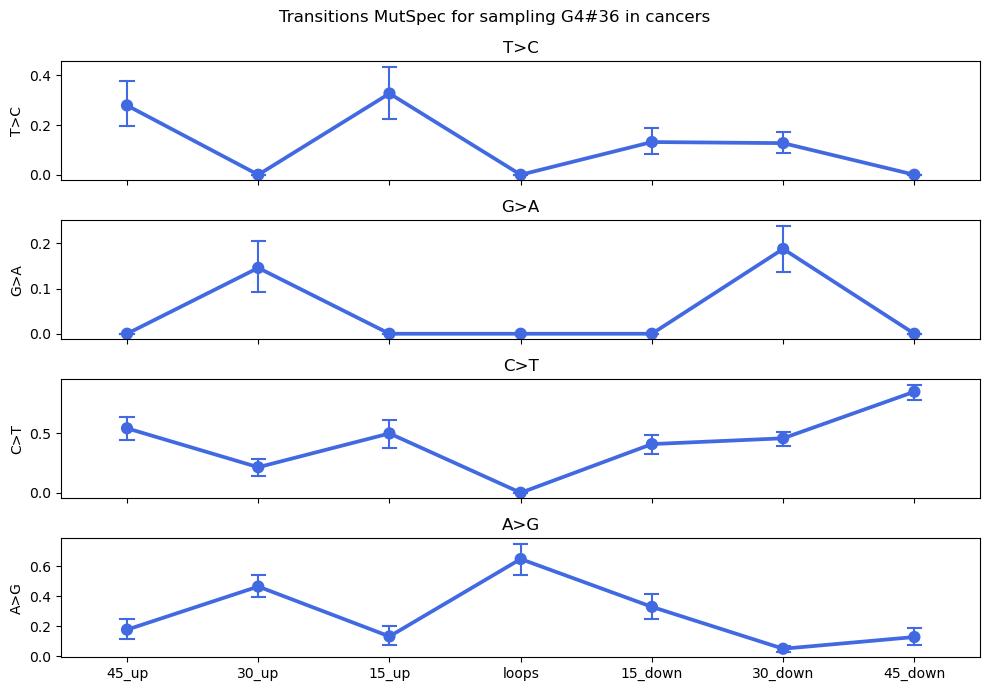

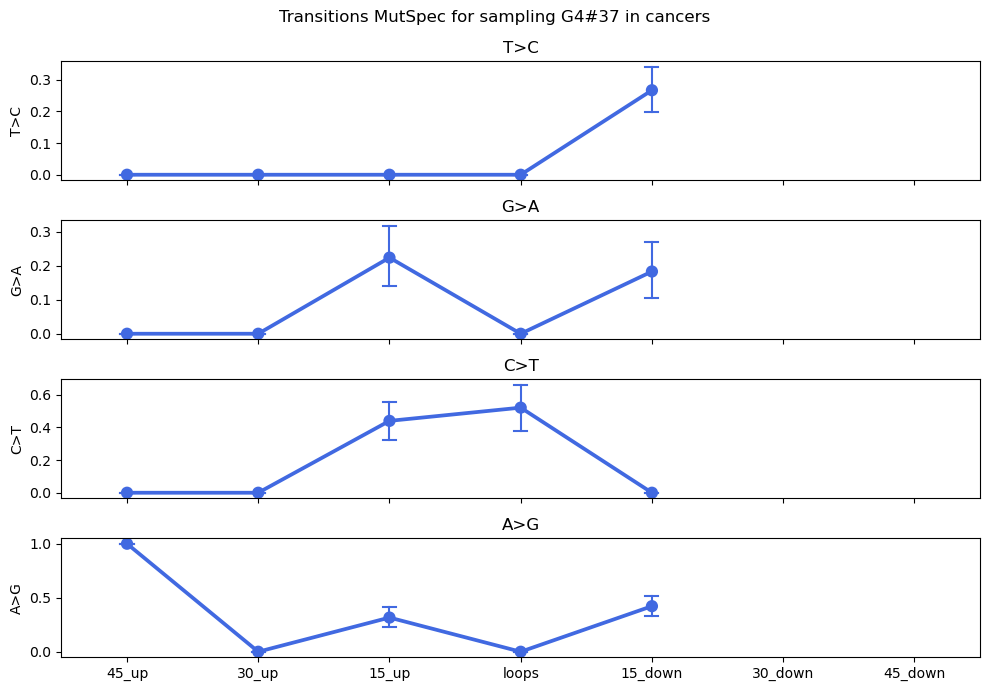

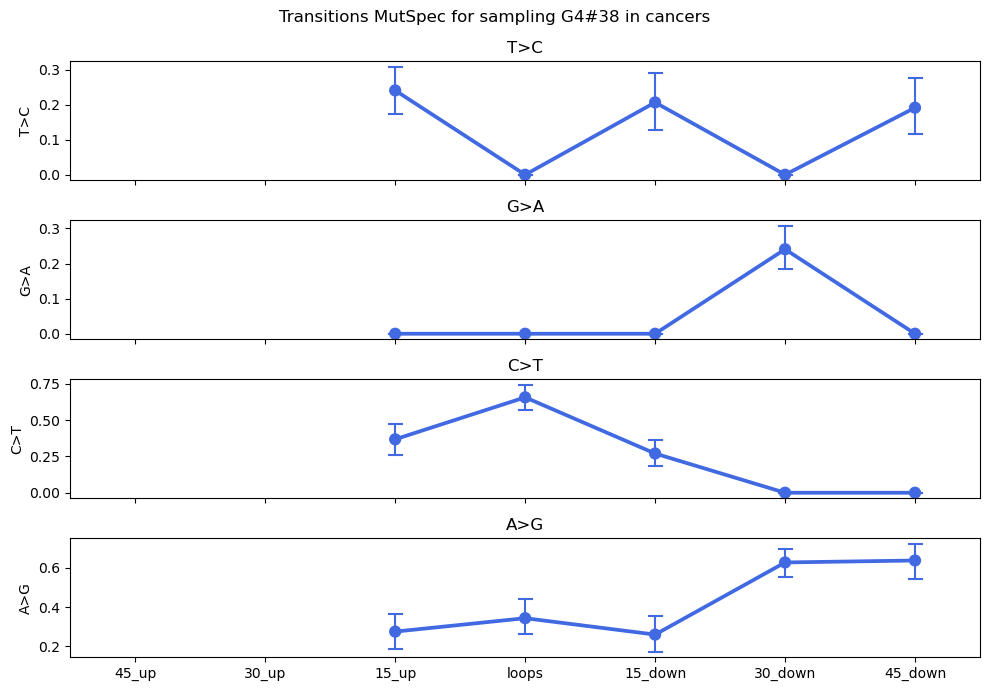

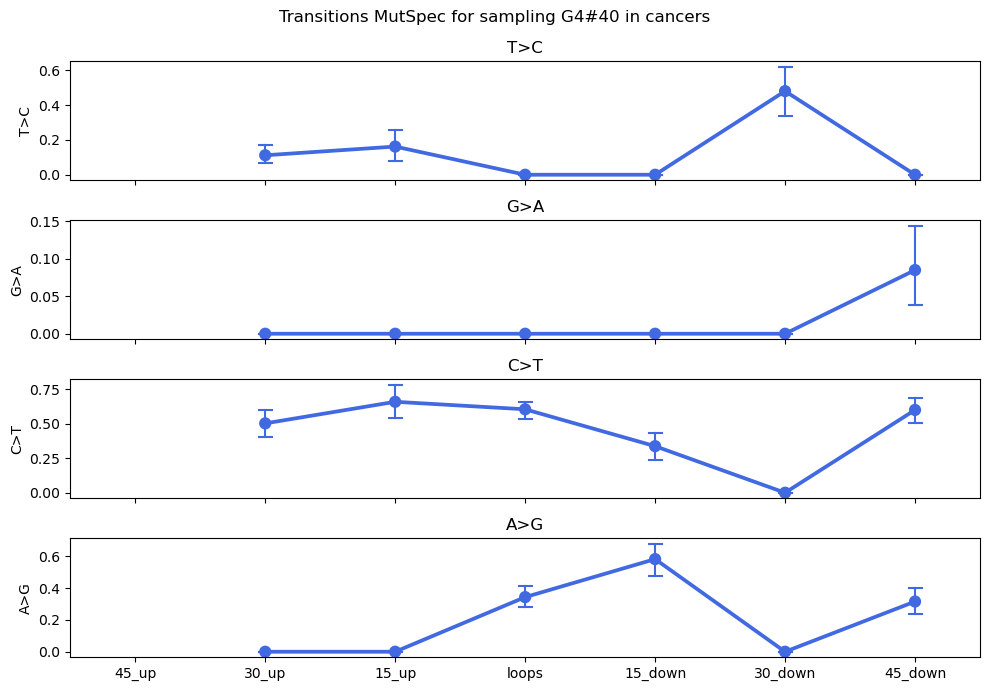

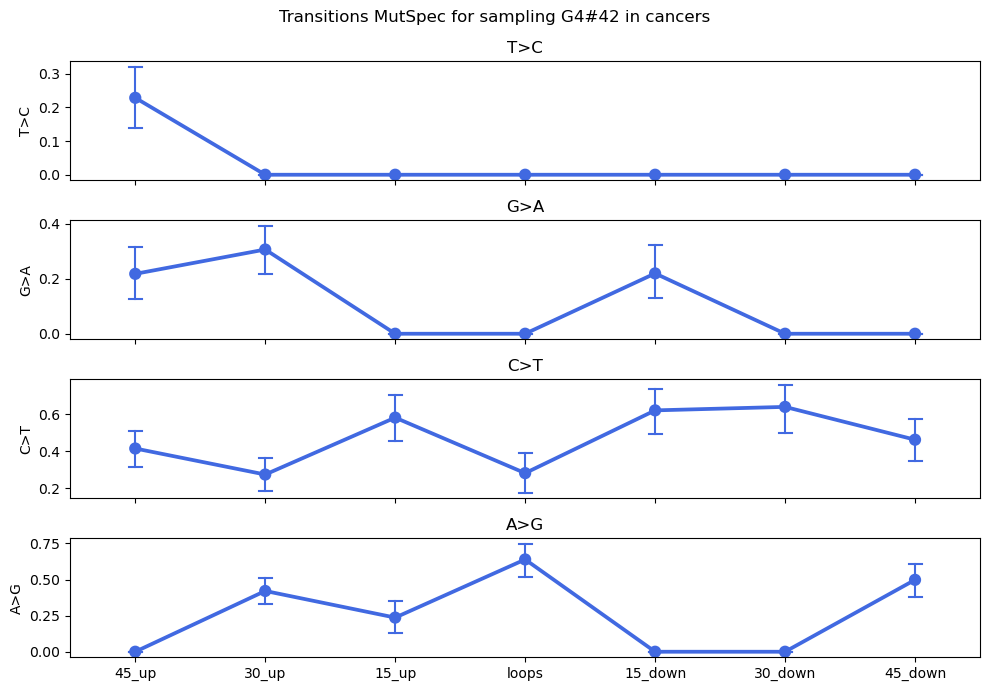

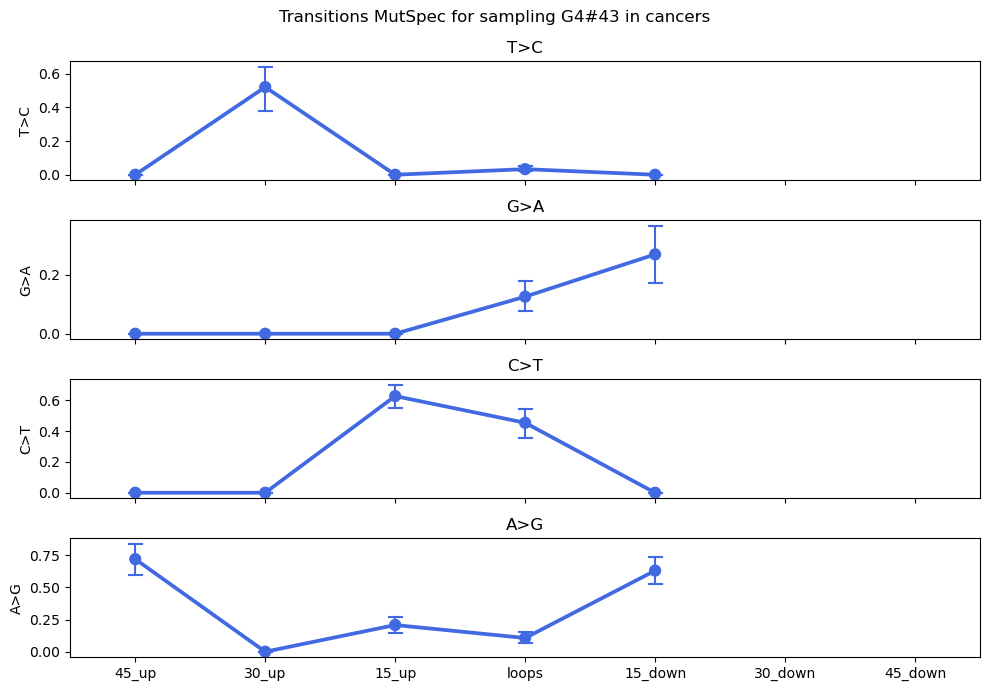

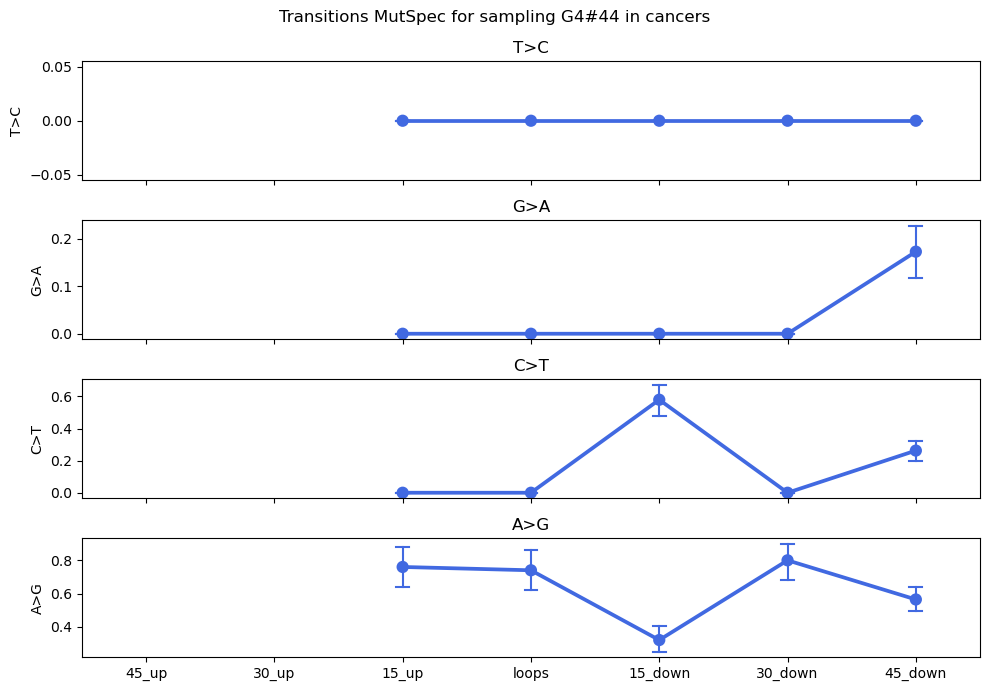

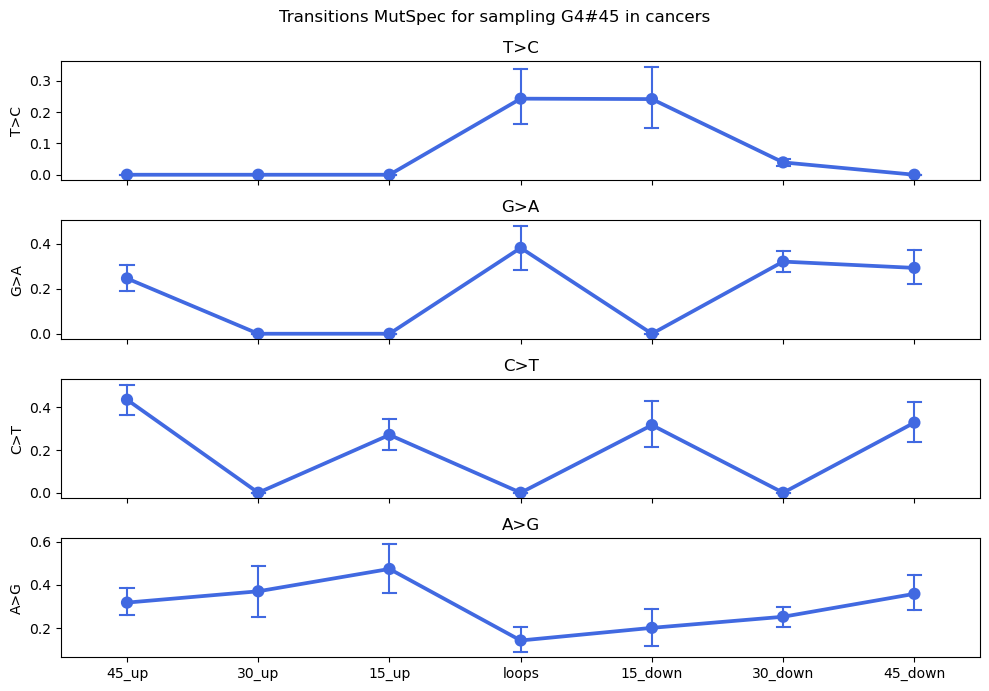

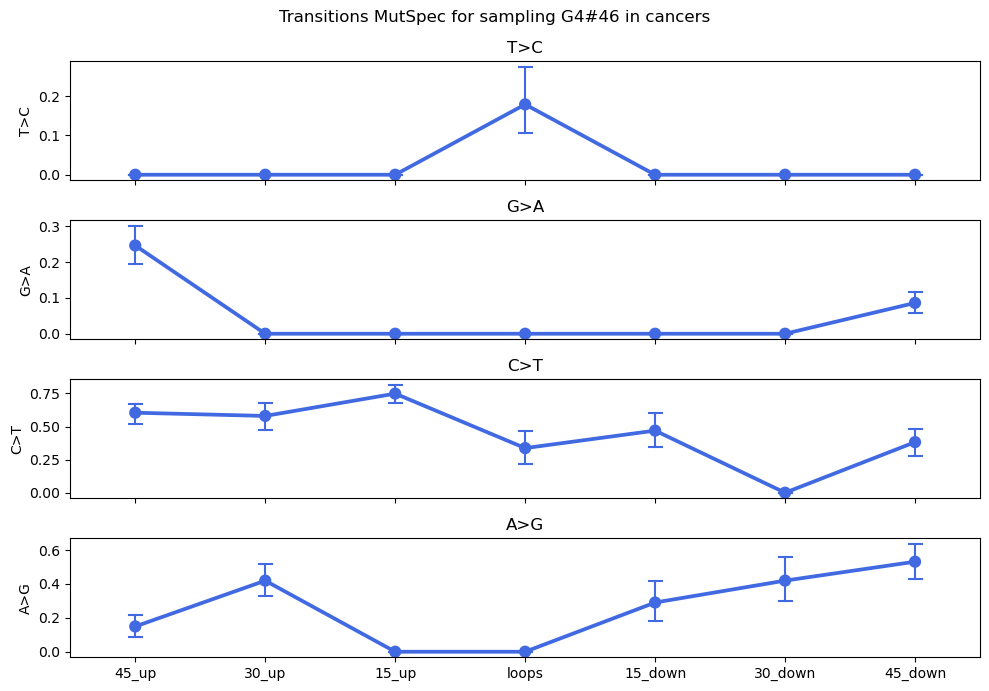

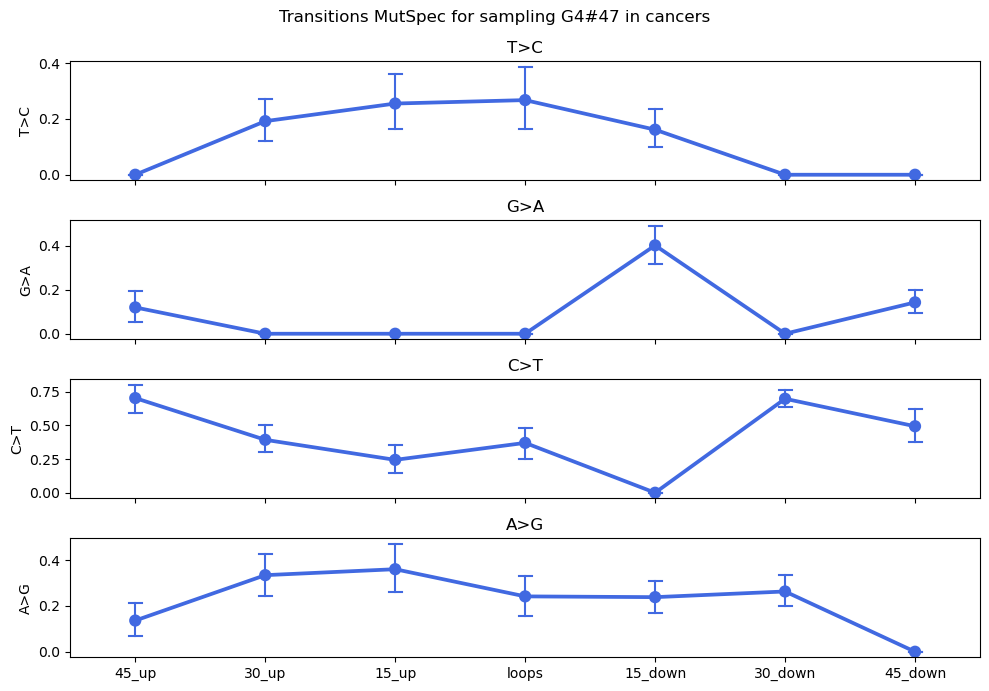

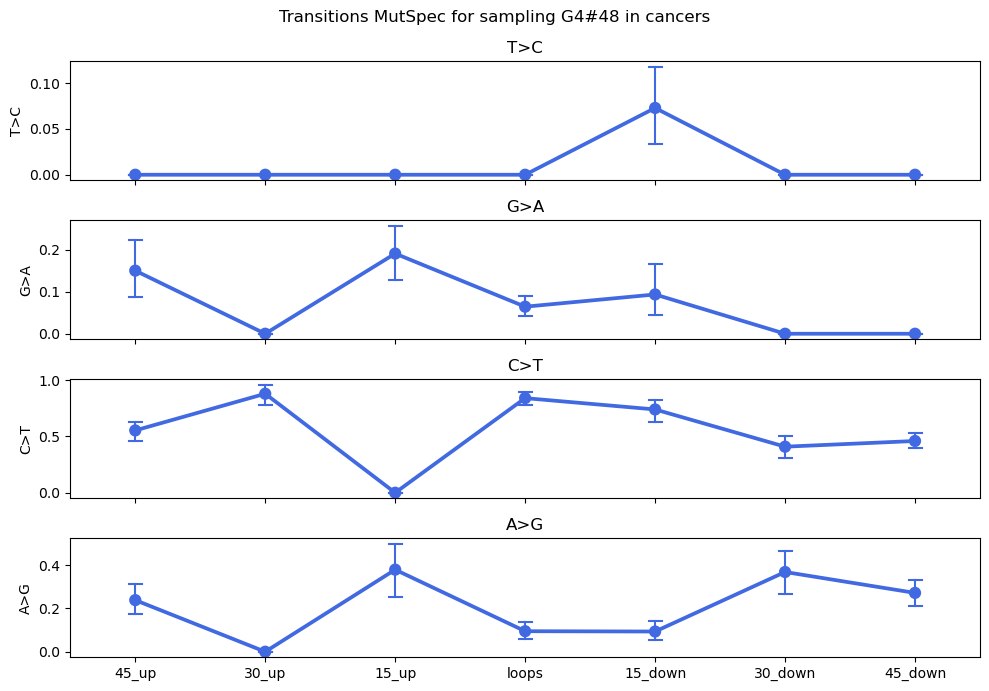

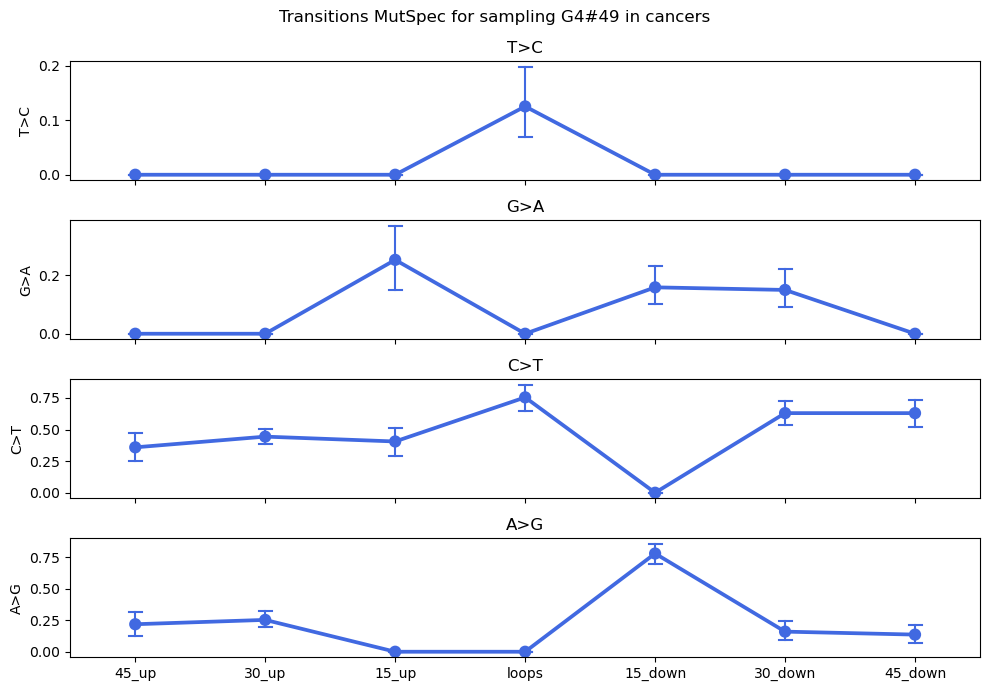

KeyboardInterrupt: 

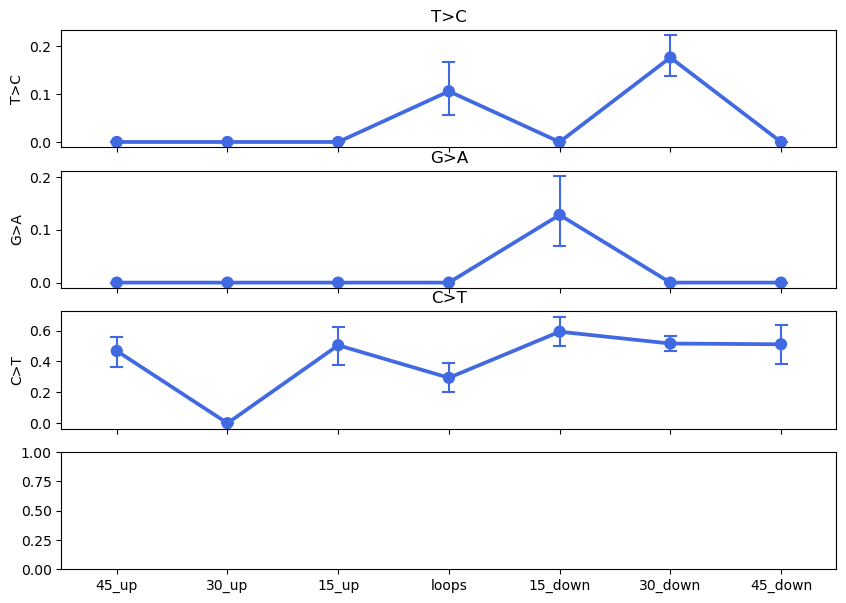

In [62]:
for G4_id in df_sample_norm_concat.G4_id.unique():
    fig, axs = plt.subplots(4, sharex=True,  figsize=(10, 7))
    mutations = ['T>C', 'G>A', 'C>T', 'A>G']
    
    colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
    order = ['45_up', '30_up', '15_up', 'loops', '15_down', '30_down', '45_down']
    
    for i, mutation in enumerate(mutations):
        row = i % 4
        sns.pointplot(data=df_sample_norm_concat[df_sample_norm_concat['G4_id'] == G4_id], 
                     x=df_sample_norm_concat[df_sample_norm_concat['G4_id'] == G4_id]['side'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
            .set(title=mutation, xlabel=None)
    
    
    plt.suptitle(f'Transitions MutSpec for sampling G4#{G4_id} in cancers')
    plt.tight_layout()
    plt.show()